# GARCH + LSTM Hybrid Model for Volatility Forecasting

This notebook implements a hybrid approach combining:
1. **GARCH Model**: Captures volatility clustering and conditional heteroskedasticity
2. **LSTM Neural Network**: Learns complex temporal patterns from volatility predictions

The hybrid model uses GARCH to generate volatility forecasts, then feeds these as features into an LSTM network for improved predictions.

In [274]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from arch import arch_model
import warnings
import random

warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
random.seed(456)
np.random.seed(456)
tf.random.set_seed(456)


## 1. Data Preparation

In [275]:
# Data Download Configuration
# S&P 500: January 1, 2002 to December 31, 2023
# Bitcoin: January 1, 2015 to December 31, 2023

# Define date ranges
sp500_start = "2002-01-01"
sp500_end = "2023-12-31"
bitcoin_start = "2015-01-01"
bitcoin_end = "2023-12-31"

print("Downloading S&P 500 data...")
# Download S&P 500 data (^GSPC is the Yahoo Finance ticker)
sp500_data = yf.download("^GSPC", start=sp500_start, end=sp500_end, progress=False)

print("Downloading Bitcoin data...")
# Download Bitcoin data (BTC-USD is the Yahoo Finance ticker)
bitcoin_data = yf.download("BTC-USD", start=bitcoin_start, end=bitcoin_end, progress=False)

print("Downloading EURUSD data...")
# Download EURUSD data
eurusd_data = yf.download("EURUSD=X", start="2009-08-11", end="2019-08-11", progress=False)

# Display basic information about downloaded data
print(f"\nS&P 500 Data Shape: {sp500_data.shape}")
print(f"S&P 500 Date Range: {sp500_data.index.min()} to {sp500_data.index.max()}")
print(f"Total S&P 500 observations: {len(sp500_data)}")

print(f"\nBitcoin Data Shape: {bitcoin_data.shape}")
print(f"Bitcoin Date Range: {bitcoin_data.index.min()} to {bitcoin_data.index.max()}")
print(f"Total Bitcoin observations: {len(bitcoin_data)}")

print(f"\nEURUSD Data Shape: {eurusd_data.shape}")
print(f"EURUSD Date Range: {eurusd_data.index.min()} to {eurusd_data.index.max()}")
print(f"Total EURUSD observations: {len(eurusd_data)}")



S&P 500 Data Shape: (5537, 5)
S&P 500 Date Range: 2002-01-02 00:00:00 to 2023-12-29 00:00:00
Total S&P 500 observations: 5537

Bitcoin Data Shape: (3286, 5)
Bitcoin Date Range: 2015-01-01 00:00:00 to 2023-12-30 00:00:00
Total Bitcoin observations: 3286

EURUSD Data Shape: (2604, 5)
EURUSD Date Range: 2009-08-11 00:00:00 to 2019-08-09 00:00:00
Total EURUSD observations: 2604


In [276]:
# Calculate log returns
sp500_data['Log_Returns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
bitcoin_data['Log_Returns'] = np.log(bitcoin_data['Close'] / bitcoin_data['Close'].shift(1))
eurusd_data['Log_Returns'] = np.log(eurusd_data['Close'] / eurusd_data['Close'].shift(1))

# Calculate realized volatility (squared returns as proxy)
sp500_data['Realized_Volatility'] = sp500_data['Log_Returns'] ** 2
bitcoin_data['Realized_Volatility'] = bitcoin_data['Log_Returns'] ** 2
eurusd_data['Realized_Volatility'] = eurusd_data['Log_Returns'] ** 2

# Drop NaN values
sp500_clean = sp500_data.dropna()
bitcoin_clean = bitcoin_data.dropna()
eurusd_clean = eurusd_data.dropna()

print("\n=== Data Summary ===")
print(f"S&P 500 clean data: {len(sp500_clean)} observations")
print(f"Bitcoin clean data: {len(bitcoin_clean)} observations")
print(f"EURUSD clean data: {len(eurusd_clean)} observations")
print(f"\nS&P 500 Log Returns - Mean: {sp500_clean['Log_Returns'].mean():.6f}, Std: {sp500_clean['Log_Returns'].std():.6f}")
print(f"Bitcoin Log Returns - Mean: {bitcoin_clean['Log_Returns'].mean():.6f}, Std: {bitcoin_clean['Log_Returns'].std():.6f}")
print(f"EURUSD Log Returns - Mean: {eurusd_clean['Log_Returns'].mean():.6f}, Std: {eurusd_clean['Log_Returns'].std():.6f}")


=== Data Summary ===
S&P 500 clean data: 5536 observations
Bitcoin clean data: 3285 observations
EURUSD clean data: 2603 observations

S&P 500 Log Returns - Mean: 0.000256, Std: 0.012245
Bitcoin Log Returns - Mean: 0.001491, Std: 0.037394
EURUSD Log Returns - Mean: -0.000090, Std: 0.005766


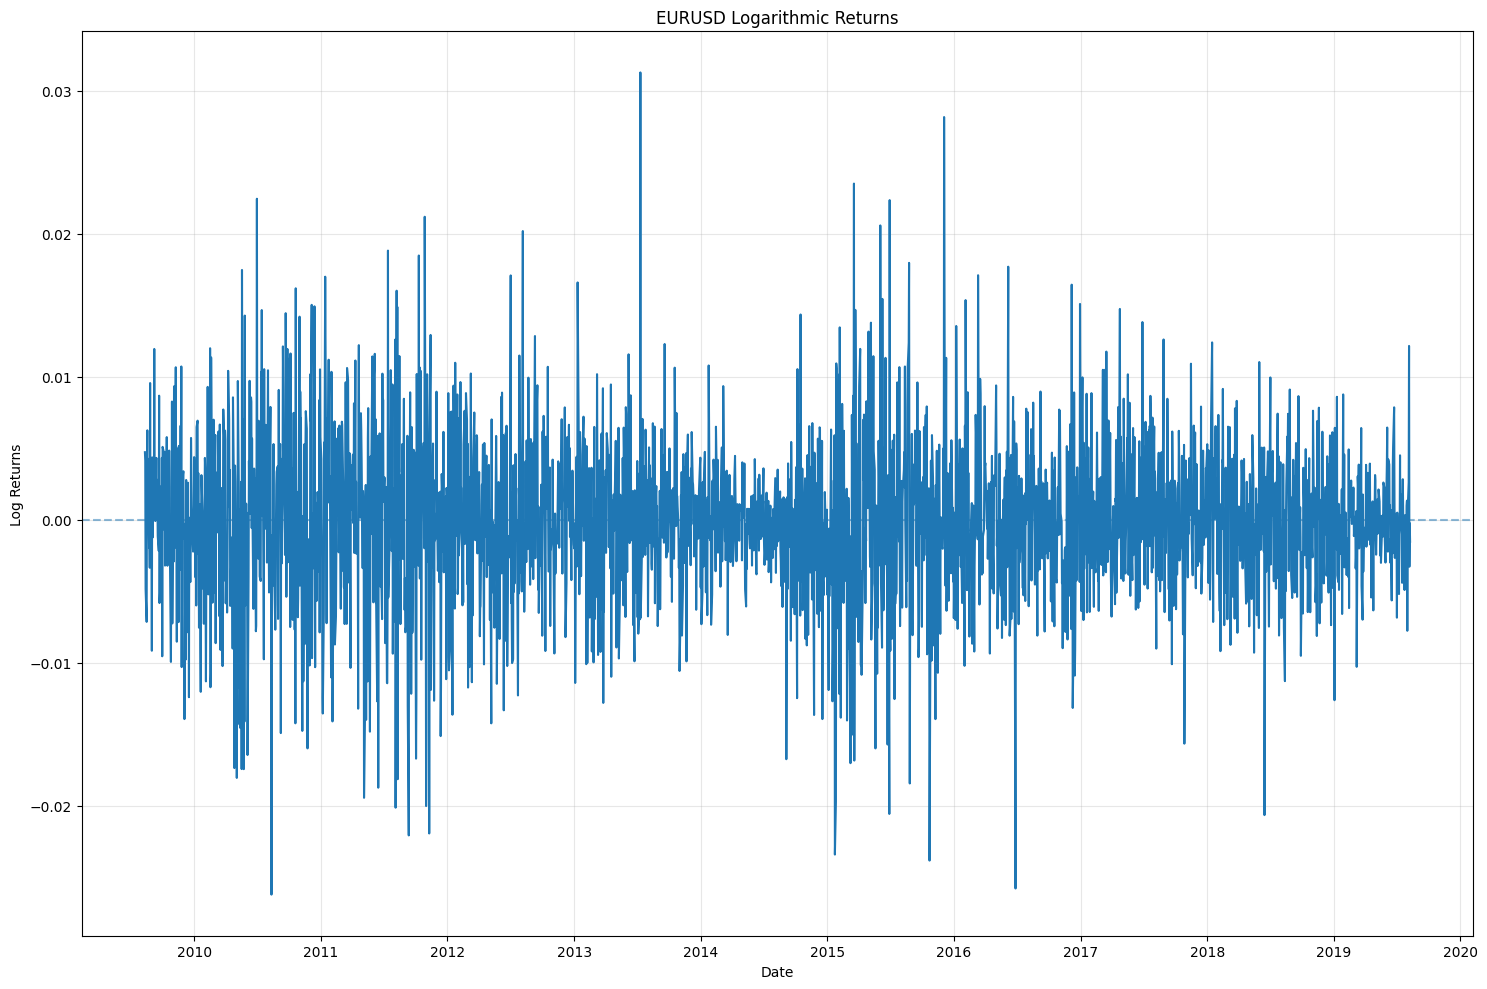

In [277]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(eurusd_clean.index, eurusd_clean['Log_Returns'])
ax.set_title('EURUSD Logarithmic Returns')
ax.set_ylabel('Log Returns')
ax.set_xlabel('Date')
ax.axhline(y=0, linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## CV Splits

In [278]:
# Time Series Cross-Validation Implementation
# Novel 3-fold cross-validation scheme with rolling windows

import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# print("=== TIME SERIES CROSS-VALIDATION IMPLEMENTATION ===\n")

def create_sp500_cv_splits(data, start_date=None):
    """
    Create S&P 500 cross-validation splits:
    - 6-year windows (3yr train + 2yr validation + 1yr test)  
    - Validation split into 8, 16, 24 months
    - Window moves 1 year forward each iteration
    """
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=3) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1) # 16 months  
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1) # 24 months (2 years)
        
        # Test period (1 year)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(years=1) - timedelta(days=1)
        
        # Check if we have enough data
        # if test_end > data.index.max():
        if test_end.year > 2024:
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2, 
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

def create_bitcoin_cv_splits(data, start_date=None):
    """
    Create Bitcoin cross-validation splits:
    - 2-year training + validation periods + 6-month test
    - Validation periods: 4, 8, 12 months
    - Window shifts forward by 6 months each iteration  
    - Testing period: 2018-01-01 to 2023-12-31
    """
    
    if start_date is None:
        # Start from a date that allows for proper window construction
        start_date = datetime(2015, 1, 1)
    
    cv_splits = []
    window_start = start_date
    
    # Define the testing period constraint
    test_period_start = datetime(2018, 1, 1)
    test_period_end = datetime(2023, 12, 31)
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (4, 8, 12 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=4) - timedelta(days=1)  # 4 months
        val2_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val3_end = val_start + relativedelta(months=12) - timedelta(days=1) # 12 months
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check constraints
        # if test_end > data.index.max() or test_end > test_period_end:
        #     break
        if test_end.year > 2023:
            break
        
        # Only include windows where test period is within 2018-2023
        if test_start < test_period_start:
            window_start += relativedelta(months=6)
            continue
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 4
                },
                {
                    'fold': 2,
                    'data': val2_data, 
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 8
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 12
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 6 months
        window_start += relativedelta(months=6)
    
    return cv_splits

def create_eurusd_cv_splits(data, start_date=None):
    """
    Create EURUSD cross-validation splits:
    - 2-year training + validation periods + 6-month test
    - Validation periods: 8, 16, 24 months
    - Window shifts forward by 1 year each iteration
    """
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1)
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1)
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check if we have enough data
        if test_end > data.index.max():
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2,
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits


In [279]:
# Create CV splits
sp500_cv_splits = create_sp500_cv_splits(sp500_clean)
bitcoin_cv_splits = create_bitcoin_cv_splits(bitcoin_clean)
eurusd_cv_splits = create_eurusd_cv_splits(eurusd_clean)


=== CROSS-VALIDATION SCHEME VISUALIZATION ===



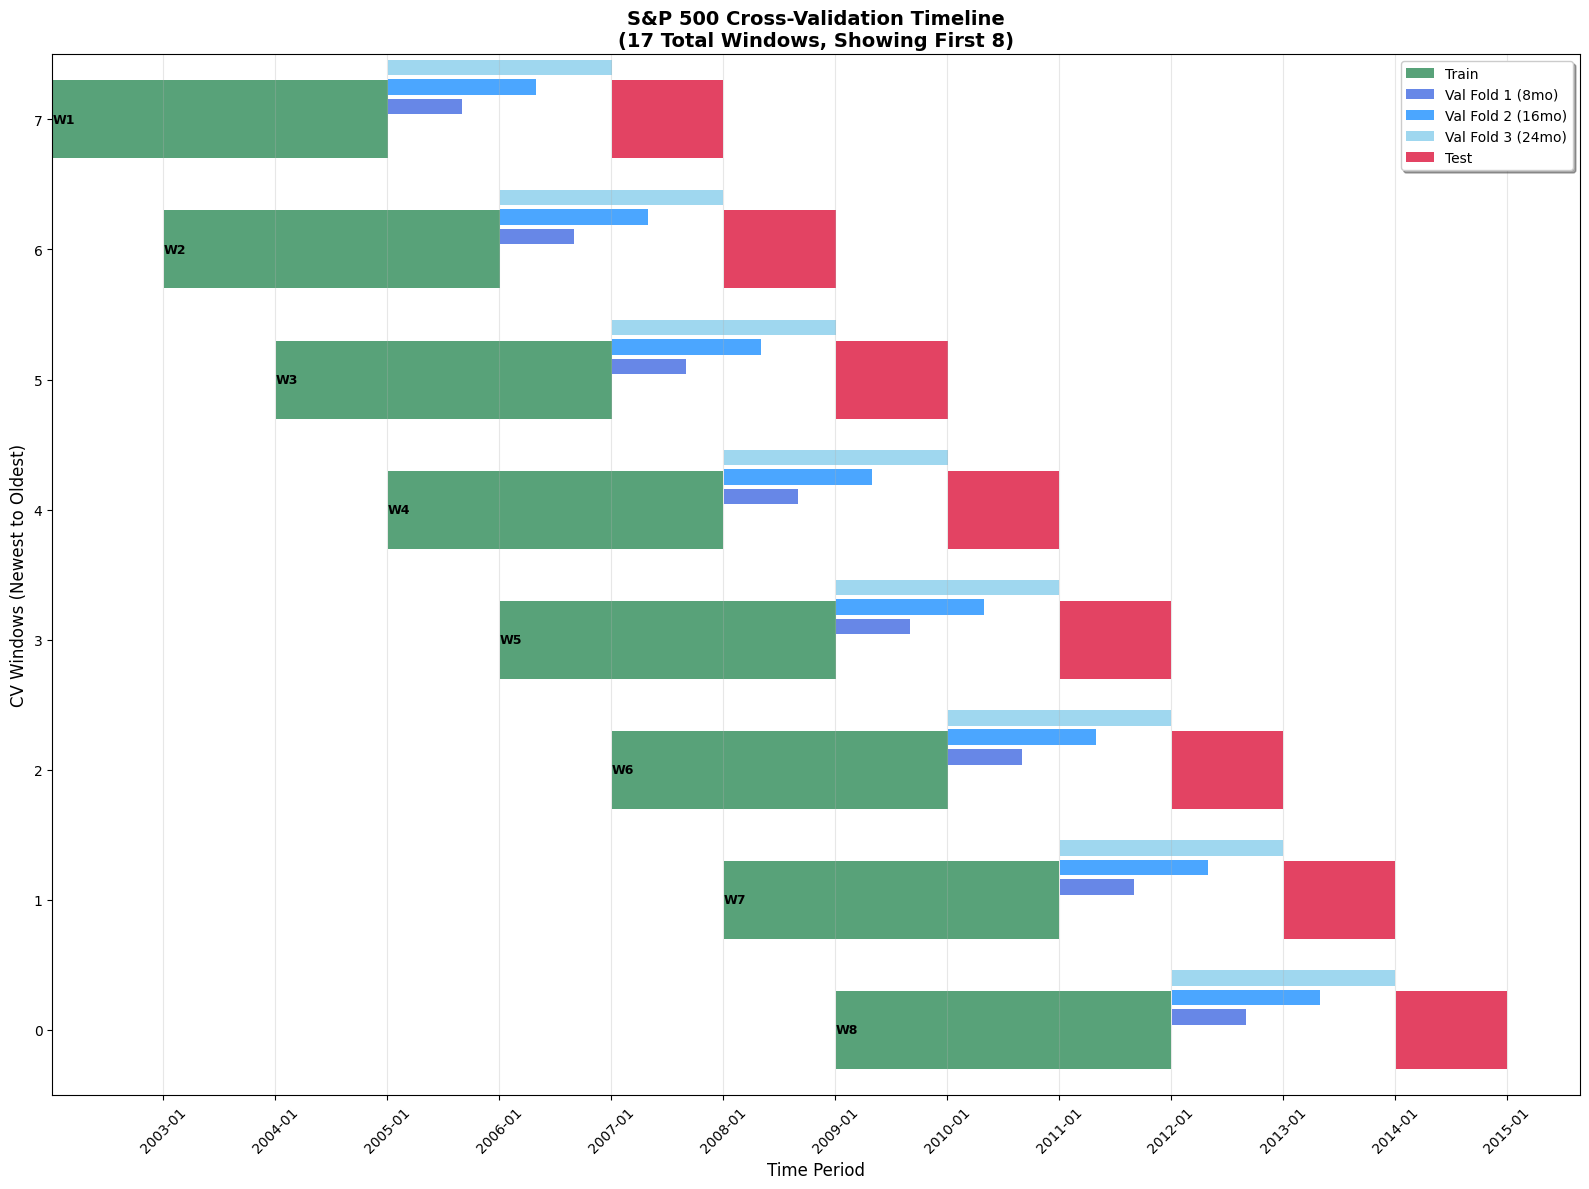

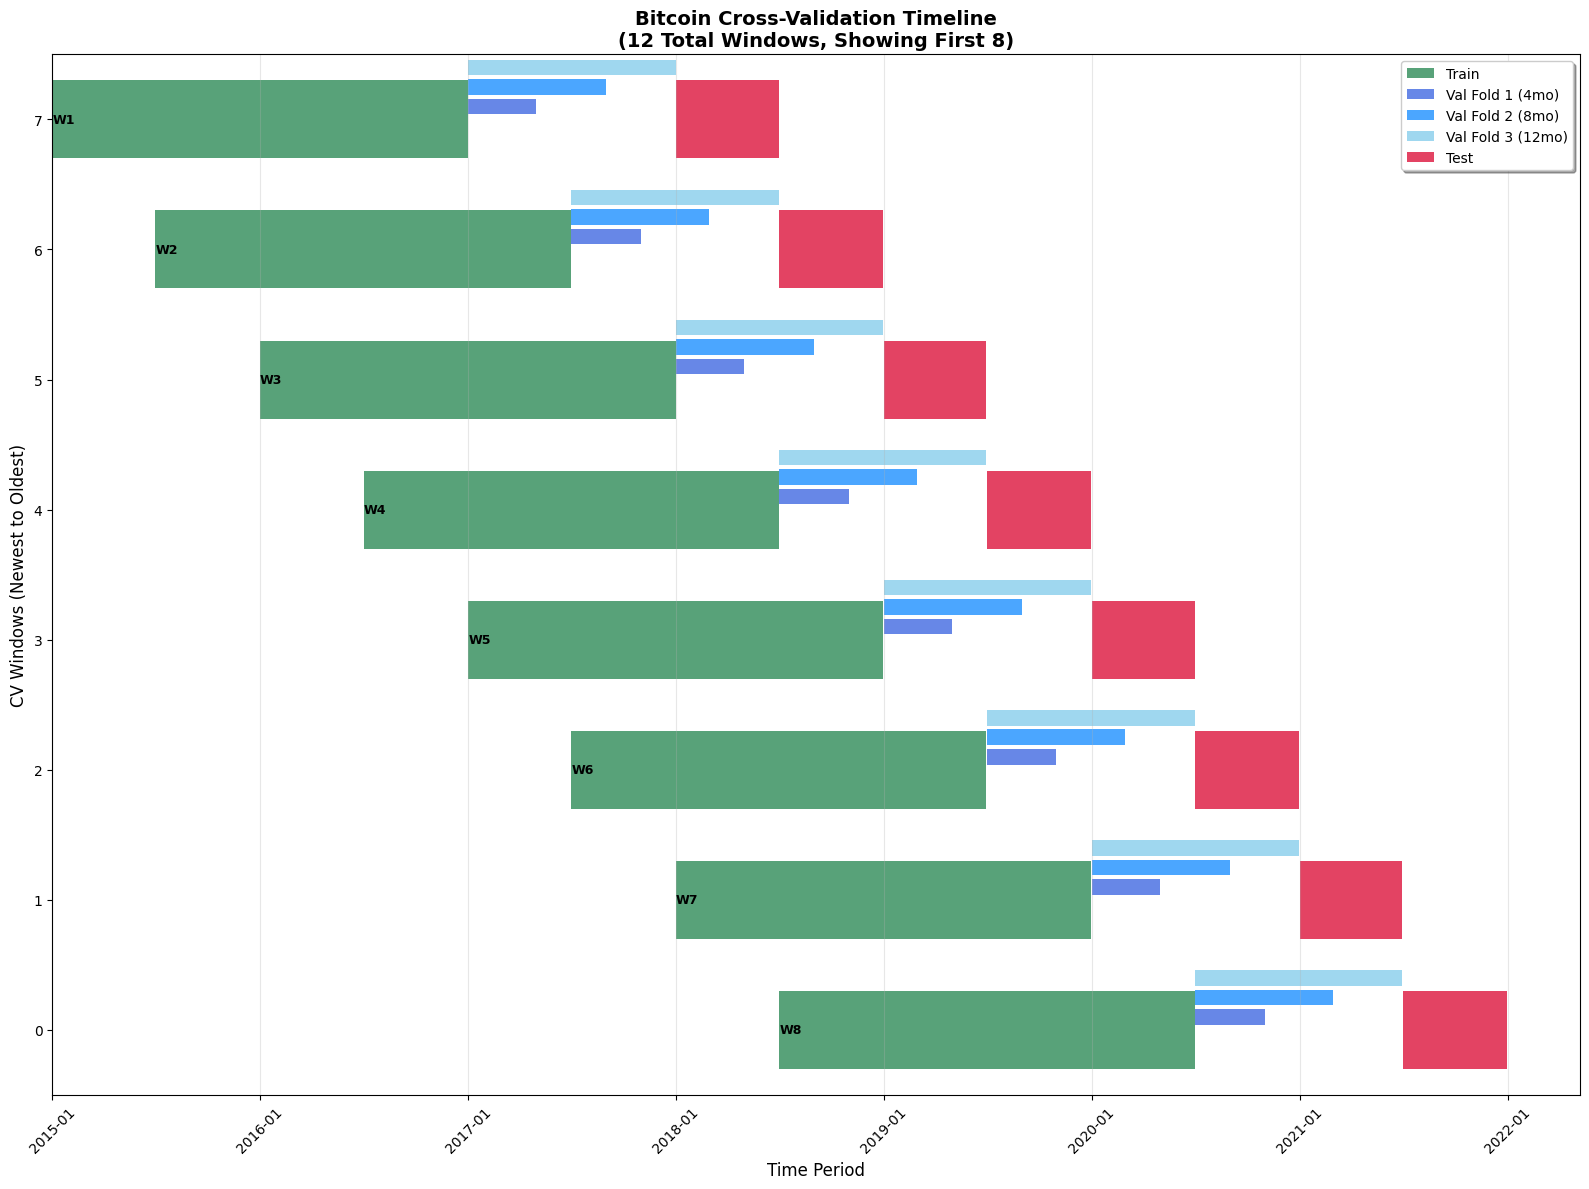

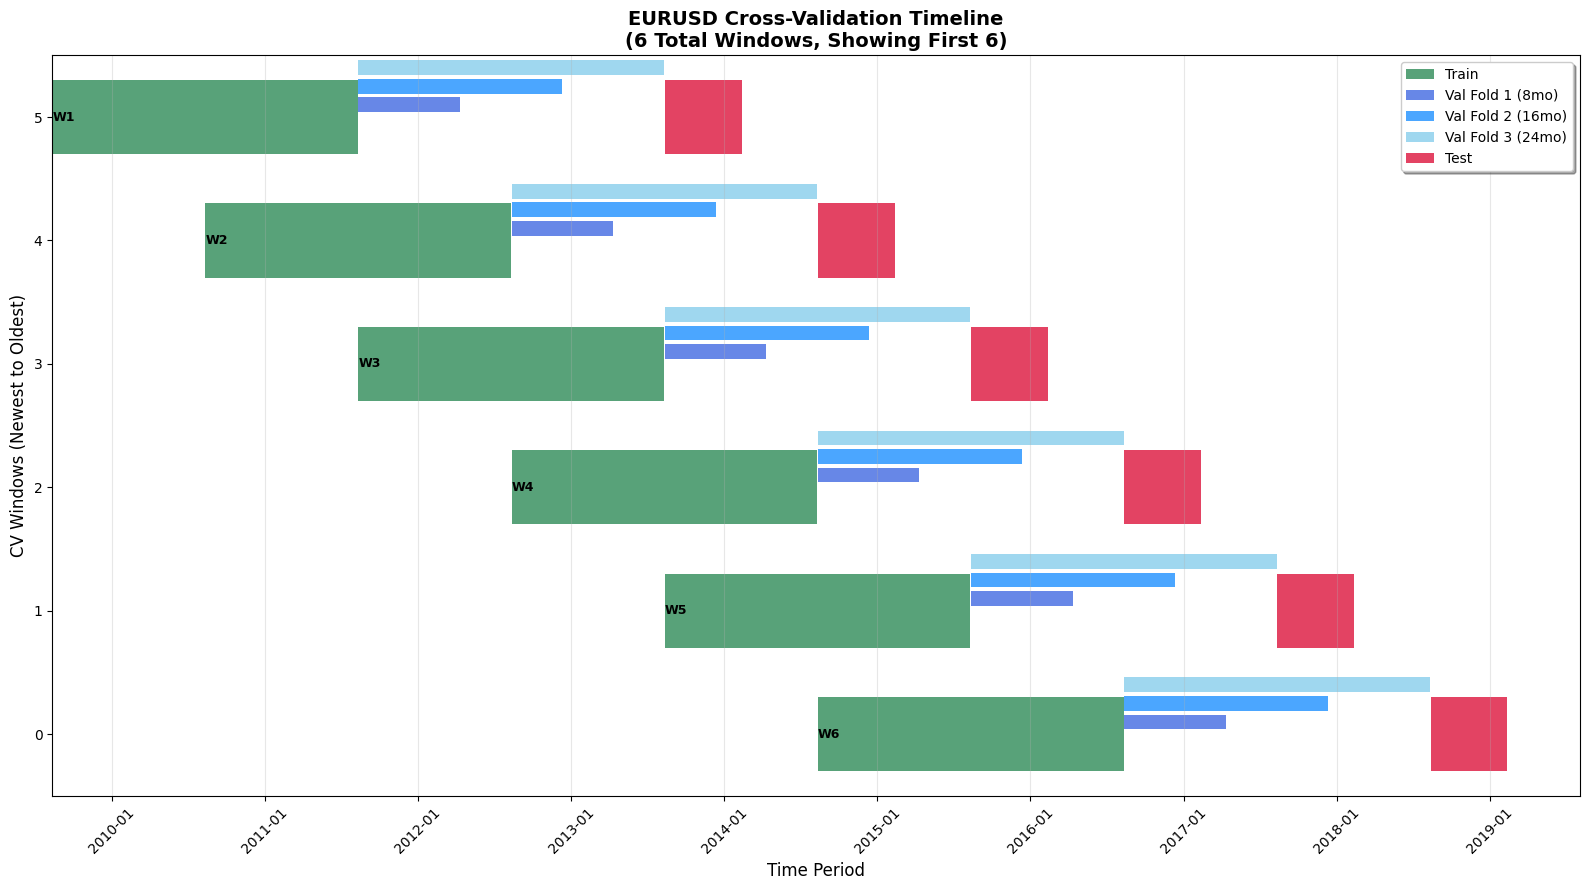

In [280]:
# Visualize Cross-Validation Scheme

def plot_cv_timeline(cv_splits, asset_name, max_windows=8):
    """Create a timeline visualization of the cross-validation scheme"""
    
    fig, ax = plt.subplots(figsize=(16, max(6, len(cv_splits[:max_windows]) * 1.5)))
    
    # Colors for different split types
    colors = {
        'train': '#2E8B57',      # Sea Green
        'val_fold1': '#4169E1',  # Royal Blue
        'val_fold2': '#1E90FF',  # Dodger Blue  
        'val_fold3': '#87CEEB',  # Sky Blue
        'test': '#DC143C'        # Crimson
    }
    
    y_positions = []
    
    for i, split in enumerate(cv_splits[:max_windows]):
        y_pos = len(cv_splits[:max_windows]) - i - 1
        y_positions.append(y_pos)
        
        # Plot training period
        ax.barh(y_pos, (split['train']['end'] - split['train']['start']).days, 
                left=split['train']['start'], height=0.6, 
                color=colors['train'], alpha=0.8, label='Train' if i == 0 else "")
        
        # Plot validation periods
        val_colors = ['val_fold1', 'val_fold2', 'val_fold3']
        for j, val_fold in enumerate(split['validation']):
            ax.barh(y_pos + 0.1 + j*0.15, (val_fold['end'] - val_fold['start']).days,
                    left=val_fold['start'], height=0.12,
                    color=colors[val_colors[j]], alpha=0.8,
                    label=f'Val Fold {j+1} ({val_fold["months"]}mo)' if i == 0 else "")
        
        # Plot test period
        ax.barh(y_pos, (split['test']['end'] - split['test']['start']).days,
                left=split['test']['start'], height=0.6,
                color=colors['test'], alpha=0.8, label='Test' if i == 0 else "")
        
        # Add window labels
        ax.text(split['train']['start'], y_pos, f'W{split["window_id"]}',
                verticalalignment='center', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.set_ylim(-0.5, len(cv_splits[:max_windows]) - 0.5)
    ax.set_ylabel('CV Windows (Newest to Oldest)', fontsize=12)
    ax.set_xlabel('Time Period', fontsize=12)
    ax.set_title(f'{asset_name} Cross-Validation Timeline\n({len(cv_splits)} Total Windows, Showing First {min(max_windows, len(cv_splits))})', 
                fontsize=14, fontweight='bold')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True, fancybox=True, shadow=True)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig, ax

print("=== CROSS-VALIDATION SCHEME VISUALIZATION ===\n")

# Create visualizations
fig1, ax1 = plot_cv_timeline(sp500_cv_splits, 'S&P 500', max_windows=8)
fig1, ax2 = plot_cv_timeline(bitcoin_cv_splits, 'Bitcoin', max_windows=8)
fig1, ax3 = plot_cv_timeline(eurusd_cv_splits, 'EURUSD', max_windows=8)
plt.show()



In [281]:
def get_cv_data(cv_splits, window_id, fold=None, return_type='data'):
    """
    Utility function to easily access cross-validation data
    
    Parameters:
    - cv_splits: List of CV splits (sp500_cv_splits or bitcoin_cv_splits)
    - window_id: Window ID (1, 2, 3, etc.)
    - fold: Validation fold (1, 2, 3) or None for train/test
    - return_type: 'train', 'validation', 'test', or 'data' (returns the data)
    
    Returns:
    - DataFrame with the requested data split
    """
    
    split = next((s for s in cv_splits if s['window_id'] == window_id), None)
    if split is None:
        raise ValueError(f"Window ID {window_id} not found")
    
    if return_type == 'train':
        return split['train']['data']
    elif return_type == 'test':
        return split['test']['data']
    elif return_type == 'validation':
        if fold is None:
            raise ValueError("Fold number must be specified for validation data")
        if fold not in [1, 2, 3]:
            raise ValueError("Fold must be 1, 2, or 3")
        return split['validation'][fold-1]['data']
    else:
        return split

## 2. GARCH Model Implementation

We'll use GARCH(1,1) which is the most common specification for financial volatility.

In [282]:
def fit_garch_model(returns, p=1, q=1):
    """
    Fit GARCH model to returns data
    
    Parameters:
    returns: pandas Series of log returns
    p: GARCH lag order
    q: ARCH lag order
    
    Returns:
    fitted model
    """
    # Multiply by 100 to scale the returns (common practice for GARCH estimation)
    returns_scaled = returns * 100
    
    # Specify GARCH model
    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, rescale=False)
    
    # Fit model
    model_fit = model.fit(disp='off')
    
    return model_fit

def get_garch_volatility(model_fit, returns):
    """
    Extract conditional volatility from fitted GARCH model
    """
    # Get conditional volatility (already in percentage scale)
    conditional_vol = model_fit.conditional_volatility / 100
    
    return conditional_vol

In [283]:
def run_garch_cross_validation(cv_splits, data_clean, asset_name, max_p=3, max_q=3, 
                               information_criterion='aic', verbose=True):
    """
    Run GARCH(p, q) model selection and evaluation across all cross-validation windows.

    Methodology:
    1. Use training data to select (p, q) via information criterion (AIC/BIC/HQIC)
    2. Validate the chosen (p, q) across the 3 validation folds (rolling 1-step-ahead forecasts)
    3. Refit on training data and evaluate on the test set (rolling 1-step-ahead forecasts)

    Parameters
    ----------
    cv_splits : list
        Cross-validation splits from create_sp500_cv_splits / create_bitcoin_cv_splits / create_eurusd_cv_splits
    data_clean : pd.DataFrame
        Clean data with 'Log_Returns' (not directly used here but kept for interface symmetry)
    asset_name : str
        Name of the asset ('S&P 500', 'Bitcoin', 'EURUSD', etc.)
    max_p, max_q : int
        Maximum orders to test for GARCH(p, q)
    information_criterion : {'aic', 'bic', 'hqic'}
        Information criterion for model selection
    verbose : bool
        Whether to print detailed progress

    Returns
    -------
    dict :
        {
            'asset_name': asset_name,
            'all_results': [ per-window detailed results dict ],
            'summary_df': pd.DataFrame of per-window metrics,
            'performance_summary': aggregate stats,
            'methodology': description dict
        }
    """
    ic_attr = information_criterion.lower()
    if ic_attr not in ['aic', 'bic', 'hqic']:
        raise ValueError("information_criterion must be one of: 'aic', 'bic', 'hqic'")

    print(f"\n=== {asset_name.upper()} GARCH CROSS-VALIDATION ===")
    print(f"Running {ic_attr.upper()}-based model selection across {len(cv_splits)} windows...")
    print(f"Parameter search space: p∈[1,{max_p}], q∈[1,{max_q}]")
    print("-" * 80)

    all_results = []
    model_selection_summary = []

    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']

        if verbose:
            print(f"\n🔄 Processing Window {window_id}/{len(cv_splits)}...")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} "
                  f"to {split['train']['end'].strftime('%Y-%m-%d')} "
                  f"({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} "
                  f"to {split['test']['end'].strftime('%Y-%m-%d')} "
                  f"({split['test']['size']} obs)")

        # ------------- STEP 0: Extract returns -------------
        train_data = split['train']['data']['Log_Returns'].copy()
        test_data = split['test']['data']['Log_Returns'].copy()

        # ------------- STEP 1: Model Selection on Train via IC -------------
        if verbose:
            print(f"   🔍 GARCH model selection using {ic_attr.upper()}...")

        best_ic = np.inf
        best_order = None
        best_model_fit = None

        for p in range(1, max_p + 1):
            for q in range(1, max_q + 1):
                try:
                    # Same scaling convention as your helper
                    returns_scaled = train_data * 100
                    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, rescale=False)
                    model_fit = model.fit(disp='off')

                    ic_value = getattr(model_fit, ic_attr)

                    if np.isfinite(ic_value) and ic_value < best_ic:
                        best_ic = ic_value
                        best_order = (p, q)
                        best_model_fit = model_fit

                except Exception as e:
                    if verbose:
                        print(f"     ⚠️  GARCH({p},{q}) failed: {str(e)[:60]}...")
                    continue

        if best_model_fit is None:
            print(f"   ❌ Failed to find suitable GARCH model for Window {window_id}")
            continue

        if verbose:
            print(f"   ✅ Selected GARCH{best_order} with {ic_attr.upper()} = {best_ic:.4f}")

        # ------------- STEP 2: Validation folds (rolling forecasts) -------------
        if verbose:
            print(f"   📊 Validating GARCH{best_order} across 3 validation folds...")

        validation_scores = []

        for val_fold in split['validation']:
            fold_num = val_fold['fold']
            val_data = val_fold['data']['Log_Returns'].copy()

            # If the fold is empty, skip
            if len(val_data) == 0:
                if verbose:
                    print(f"     ⚠️  Validation fold {fold_num} is empty, skipping.")
                continue

            try:
                history = train_data.copy()
                val_forecast_vol = []

                # Rolling 1-step-ahead forecasts through the validation period
                for t_idx, (val_date, ret) in enumerate(val_data.items()):
                    model_fit_t = fit_garch_model(history, p=best_order[0], q=best_order[1])
                    cond_vol_t = get_garch_volatility(model_fit_t, history)
                    forecast_vol_t = cond_vol_t.iloc[-1]  # one-step-ahead for this date

                    val_forecast_vol.append(forecast_vol_t)

                    # Expand history to include this observed return
                    history = pd.concat([history, pd.Series([ret], index=[val_date])])

                val_forecast_vol = pd.Series(val_forecast_vol, index=val_data.index)
                realized_vol_val = np.abs(val_data)

                mask_val = val_forecast_vol.notna() & realized_vol_val.notna()
                if mask_val.sum() == 0:
                    if verbose:
                        print(f"     ⚠️  No valid forecasts in validation fold {fold_num}")
                    val_rmse = np.inf
                else:
                    val_rmse = np.sqrt(mean_squared_error(realized_vol_val[mask_val],
                                                          val_forecast_vol[mask_val]))

                validation_scores.append(val_rmse)

                if verbose:
                    print(f"     ✅ Fold {fold_num}: Validation RMSE={val_rmse:.6f}")

            except Exception as e:
                if verbose:
                    print(f"     ⚠️  Validation fold {fold_num} failed: {str(e)[:60]}...")
                validation_scores.append(np.inf)

        avg_validation_rmse = (np.mean(validation_scores)
                               if len(validation_scores) > 0
                               else np.inf)

        # ------------- STEP 3: Final test evaluation (rolling forecasts) -------------
        if verbose:
            print("   🎯 Final evaluation on test data...")

        try:
            # Keep best_model_fit for reference, but we'll do rolling forecasts like validation
            history = train_data.copy()
            test_forecast_vol = []

            for t_idx, (test_date, ret) in enumerate(test_data.items()):
                model_fit_t = fit_garch_model(history, p=best_order[0], q=best_order[1])
                cond_vol_t = get_garch_volatility(model_fit_t, history)
                forecast_vol_t = cond_vol_t.iloc[-1]

                test_forecast_vol.append(forecast_vol_t)
                history = pd.concat([history, pd.Series([ret], index=[test_date])])

            test_forecast_vol = pd.Series(test_forecast_vol, index=test_data.index)
            realized_vol_test = np.abs(test_data)

            mask_test = test_forecast_vol.notna() & realized_vol_test.notna()
            if mask_test.sum() == 0:
                print(f"   ❌ No valid test forecasts for Window {window_id}")
                continue

            test_rmse = np.sqrt(mean_squared_error(realized_vol_test[mask_test],
                                                   test_forecast_vol[mask_test]))
            test_mae = mean_absolute_error(realized_vol_test[mask_test],
                                           test_forecast_vol[mask_test])

            if verbose:
                print(f"   ✅ GARCH{best_order}: Test RMSE={test_rmse:.6f}, Test MAE={test_mae:.6f}")

            # In-sample train metrics from the selected model
            train_cond_vol = get_garch_volatility(best_model_fit, train_data)
            realized_vol_train = np.abs(train_data)

            train_rmse = np.sqrt(mean_squared_error(realized_vol_train, train_cond_vol))
            train_mae = mean_absolute_error(realized_vol_train, train_cond_vol)

            # ------------- Store detailed window result -------------
            window_result = {
                'window_id': window_id,
                'asset': asset_name,
                'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} "
                                f"to {split['train']['end'].strftime('%Y-%m-%d')}",
                'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} "
                               f"to {split['test']['end'].strftime('%Y-%m-%d')}",
                'train_size': split['train']['size'],
                'test_size': split['test']['size'],
                'best_order': best_order,
                'best_ic_value': best_ic,
                'validation_scores': validation_scores,
                'avg_validation_rmse': avg_validation_rmse,
                'train_cond_vol': train_cond_vol,
                'test_forecast_vol': test_forecast_vol,
                'realized_vol_train': realized_vol_train,
                'realized_vol_test': realized_vol_test,
                'metrics': {
                    'train_rmse': train_rmse,
                    'train_mae': train_mae,
                    'test_rmse': test_rmse,
                    'test_mae': test_mae
                },
                'final_model': best_model_fit
            }

            all_results.append(window_result)

            # Summary row for quick reference (similar structure to ARIMA summary)
            model_selection_summary.append({
                'Window': window_id,
                'Best_Order': f"GARCH{best_order}",
                ic_attr.upper(): best_ic,
                'Validation_RMSE': avg_validation_rmse,
                'Train_RMSE': train_rmse,
                'Train_MAE': train_mae,
                'Test_RMSE': test_rmse,
                'Test_MAE': test_mae
            })

        except Exception as e:
            print(f"   ❌ Final evaluation failed for Window {window_id}: {str(e)[:80]}")
            continue

    # ------------- Build summary df & aggregate stats -------------
    summary_df = pd.DataFrame(model_selection_summary)

    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse': summary_df['Test_RMSE'].mean(),
            'std_test_rmse': summary_df['Test_RMSE'].std(),
            'avg_test_mae': summary_df['Test_MAE'].mean(),
            'avg_train_rmse': summary_df['Train_RMSE'].mean(),
            'avg_train_mae': summary_df['Train_MAE'].mean(),
            'avg_validation_rmse': summary_df['Validation_RMSE'].mean(),
            'most_common_order': summary_df['Best_Order'].mode().iloc[0]
                                 if len(summary_df) > 0 else None
        }
    else:
        performance_summary = None

    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} GARCH CROSS-VALIDATION COMPLETE")
    print(f"{'='*80}")

    if performance_summary:
        print(f"✅ Successfully processed {performance_summary['successful_windows']}/"
              f"{performance_summary['total_windows']} windows")
        print(f"📊 Average Test RMSE: {performance_summary['avg_test_rmse']:.6f} "
              f"± {performance_summary['std_test_rmse']:.6f}")
        print(f"🎯 Average Validation RMSE: {performance_summary['avg_validation_rmse']:.6f}")
        print(f"🔄 Most Common Model: {performance_summary['most_common_order']}")
    else:
        print("❌ No successful model fits achieved")

    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'approach': f'{ic_attr.upper()}-based GARCH(p, q) selection',
            'information_criterion': information_criterion,
            'parameter_space': f'p∈[1,{max_p}], q∈[1,{max_q}]',
            'cross_validation': '3-fold temporal validation with rolling 1-step-ahead forecasts',
            'evaluation_metric': 'RMSE and MAE between predicted and realized volatility (|returns|)'
        }
    }


In [304]:
sp500_cv_splits = create_sp500_cv_splits(sp500_clean)
bitcoin_cv_splits = create_bitcoin_cv_splits(bitcoin_clean)
eurusd_cv_splits = create_eurusd_cv_splits(eurusd_clean)

garch_results_sp = run_garch_cross_validation(sp500_cv_splits, sp500_clean, 'S&P 500')



=== S&P 500 GARCH CROSS-VALIDATION ===
Running AIC-based model selection across 17 windows...
Parameter search space: p∈[1,3], q∈[1,3]
--------------------------------------------------------------------------------

🔄 Processing Window 1/17...
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(2, 1) with AIC = 2194.9680
   📊 Validating GARCH(2, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.004071
     ✅ Fold 2: Validation RMSE=0.004233
     ✅ Fold 3: Validation RMSE=0.004381
   🎯 Final evaluation on test data...
   ✅ GARCH(2, 1): Test RMSE=0.007076, Test MAE=0.005663

🔄 Processing Window 2/17...
   Train: 2003-01-03 to 2006-01-02 (755 obs)
   Test:  2008-01-03 to 2009-01-02 (253 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 1) with AIC = 1745.5892
   📊 Validating GARCH(1, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.004805
   

In [305]:
garch_results_btc = run_garch_cross_validation(bitcoin_cv_splits, bitcoin_clean, 'Bitcoin')


=== BITCOIN GARCH CROSS-VALIDATION ===
Running AIC-based model selection across 12 windows...
Parameter search space: p∈[1,3], q∈[1,3]
--------------------------------------------------------------------------------

🔄 Processing Window 1/12...
   Train: 2015-01-01 to 2016-12-31 (730 obs)
   Test:  2018-01-01 to 2018-06-30 (181 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 3) with AIC = 3516.2915
   📊 Validating GARCH(1, 3) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.033909
     ✅ Fold 2: Validation RMSE=0.033727
     ✅ Fold 3: Validation RMSE=0.038448
   🎯 Final evaluation on test data...
   ✅ GARCH(1, 3): Test RMSE=0.036637, Test MAE=0.029253

🔄 Processing Window 2/12...
   Train: 2015-07-01 to 2017-06-30 (731 obs)
   Test:  2018-07-01 to 2018-12-31 (184 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 2) with AIC = 3591.9836
   📊 Validating GARCH(1, 2) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.042946
   

In [306]:
garch_results_eur = run_garch_cross_validation(eurusd_cv_splits, eurusd_clean, 'EURUSD')


=== EURUSD GARCH CROSS-VALIDATION ===
Running AIC-based model selection across 6 windows...
Parameter search space: p∈[1,3], q∈[1,3]
--------------------------------------------------------------------------------

🔄 Processing Window 1/6...
   Train: 2009-08-12 to 2011-08-11 (522 obs)
   Test:  2013-08-12 to 2014-02-11 (131 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 1) with AIC = 1110.2998
   📊 Validating GARCH(1, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.005067
     ✅ Fold 2: Validation RMSE=0.004574
     ✅ Fold 3: Validation RMSE=0.004421
   🎯 Final evaluation on test data...
   ✅ GARCH(1, 1): Test RMSE=0.003986, Test MAE=0.003506

🔄 Processing Window 2/6...
   Train: 2010-08-12 to 2012-08-11 (522 obs)
   Test:  2014-08-12 to 2015-02-11 (132 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 1) with AIC = 1146.9337
   📊 Validating GARCH(1, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.003590
     ✅ 

In [301]:
# ============================================================
# Comprehensive GARCH Results Analysis and Visualization
# ============================================================

def create_garch_results_summary(sp500_results, bitcoin_results,eurusd_results):
    
    print("\n" + "="*100)
    print("COMPREHENSIVE GARCH ANALYSIS RESULTS")  
    print("="*100)
    
    # Combined summary statistics
    summary_stats = {
        'Asset': ['S&P 500', 'Bitcoin','EURUSD'],
        'Total_Windows': [
            sp500_results['performance_summary']['total_windows'] 
            if sp500_results['performance_summary'] else 0,
            bitcoin_results['performance_summary']['total_windows'] 
            if bitcoin_results['performance_summary'] else 0,
            eurusd_results['performance_summary']['total_windows'] 
            if eurusd_results['performance_summary'] else 0
        ],
        'Avg_Train_RMSE': [
            sp500_results['performance_summary']['avg_train_rmse'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_train_rmse'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_train_rmse'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Avg_Validation_RMSE': [
            sp500_results['performance_summary']['avg_validation_rmse'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_validation_rmse'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_validation_rmse'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Avg_Test_RMSE': [
            sp500_results['performance_summary']['avg_test_rmse'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_test_rmse'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_test_rmse'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Avg_Test_MAE': [
            sp500_results['performance_summary']['avg_test_mae'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_test_mae'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_test_mae'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Most_Common_Model': [
            sp500_results['performance_summary']['most_common_order'] 
            if sp500_results['performance_summary'] else 'N/A',
            bitcoin_results['performance_summary']['most_common_order'] 
            if bitcoin_results['performance_summary'] else 'N/A',
            eurusd_results['performance_summary']['most_common_order'] 
            if eurusd_results['performance_summary'] else 'N/A'
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    
    print("\n📊 OVERALL PERFORMANCE SUMMARY (GARCH)")
    print("-" * 50)
    print(summary_df.to_string(index=False, float_format='%.6f'))
    
    # Detailed window-by-window results
    if len(sp500_results['summary_df']) > 0:
        print(f"\n📈 S&P 500 GARCH DETAILED RESULTS ({len(sp500_results['summary_df'])} windows)")
        print("-" * 50)
        print(sp500_results['summary_df'].round(6).to_string(index=False))
    
    if len(bitcoin_results['summary_df']) > 0:
        print(f"\n🪙 BITCOIN GARCH DETAILED RESULTS ({len(bitcoin_results['summary_df'])} windows)")
        print("-" * 50)
        print(bitcoin_results['summary_df'].round(6).to_string(index=False))
    
    if len(eurusd_results['summary_df']) > 0:
        print(f"\n🪙 EURUSD GARCH DETAILED RESULTS ({len(eurusd_results['summary_df'])} windows)")
        print("-" * 50)
        print(eurusd_results['summary_df'].round(6).to_string(index=False))
    
    return summary_df


In [302]:
def plot_garch_performance_analysis(sp500_results, bitcoin_results,eurusd_results):    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GARCH Model Performance Analysis\nConditional Volatility Forecasting', 
                 fontsize=16, fontweight='bold')
    
    sp500_df = sp500_results['summary_df'] if len(sp500_results['summary_df']) > 0 else pd.DataFrame()
    bitcoin_df = bitcoin_results['summary_df'] if len(bitcoin_df := bitcoin_results['summary_df']) > 0 else pd.DataFrame()
    eurusd_df = eurusd_results['summary_df'] if len(eurusd_results['summary_df']) > 0 else pd.DataFrame()

    # Plot 1: Test RMSE Comparison
    ax1 = axes[0, 0]
    if len(sp500_df) > 0 and len(bitcoin_df) > 0 and len(eurusd_df) > 0:
        ax1.boxplot(
            [sp500_df['Test_RMSE'], bitcoin_df['Test_RMSE'],eurusd_df['Test_RMSE']], 
            labels=['S&P 500', 'Bitcoin','EURUSD'], 
            patch_artist=True
        )
        ax1.set_title('Test RMSE Distribution (GARCH)')
        ax1.set_ylabel('RMSE')
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Validation RMSE Comparison  
    ax2 = axes[0, 1]
    if len(sp500_df) > 0 and len(bitcoin_df) > 0 and len(eurusd_df) > 0:
        ax2.boxplot(
            [sp500_df['Validation_RMSE'], bitcoin_df['Validation_RMSE'],eurusd_df['Validation_RMSE']], 
            labels=['S&P 500', 'Bitcoin','EURUSD'], 
            patch_artist=True
        )
        ax2.set_title('Validation RMSE Distribution')
        ax2.set_ylabel('RMSE')
        ax2.grid(True, alpha=0.3)
    
    # # Plot 3: Model Order Distribution
    # ax3 = axes[0, 2]
    # combined_orders = []
    # if len(sp500_df) > 0:
    #     combined_orders.extend(sp500_df['Best_Order'].tolist())
    # if len(bitcoin_df) > 0:
    #     combined_orders.extend(bitcoin_df['Best_Order'].tolist())
    # if len(eurusd_df) > 0:
    #     combined_orders.extend(eurusd_df['Best_Order'].tolist())
    
    # if combined_orders:
    #     order_counts = pd.Series(combined_orders).value_counts()
    #     order_counts.head(10).plot(kind='bar', ax=ax3, alpha=0.7)
    #     ax3.set_title('Most Frequent GARCH Orders')
    #     ax3.set_xlabel('GARCH(p, q)')
    #     ax3.set_ylabel('Frequency')
    #     ax3.tick_params(axis='x', rotation=45)
    #     ax3.grid(True, alpha=0.3)
    
    # Plot 3: RMSE over Windows (S&P 500)
    ax3 = axes[0,2]
    if len(sp500_df) > 0:
        ax3.plot(sp500_df['Window'], sp500_df['Test_RMSE'], 'o-', alpha=0.7, label='Test RMSE')
        ax3.plot(sp500_df['Window'], sp500_df['Validation_RMSE'], 's--', alpha=0.7, label='Validation RMSE')
        ax3.set_title('S&P 500 RMSE Evolution (GARCH)')
        ax3.set_xlabel('Window')
        ax3.set_ylabel('RMSE')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    # Plot 4: RMSE over Windows (Bitcoin)
    ax4 = axes[1, 0]  
    if len(bitcoin_df) > 0:
        ax4.plot(bitcoin_df['Window'], bitcoin_df['Test_RMSE'], 'o-', alpha=0.7, label='Test RMSE')
        ax4.plot(bitcoin_df['Window'], bitcoin_df['Validation_RMSE'], 's--', alpha=0.7, label='Validation RMSE')
        ax4.set_title('Bitcoin RMSE Evolution (GARCH)')
        ax4.set_xlabel('Window')
        ax4.set_ylabel('RMSE')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    # Plot 5: RMSE over Windows (EURUSD)
    ax5 = axes[1, 1]  
    if len(eurusd_df) > 0:
        ax5.plot(eurusd_df['Window'], eurusd_df['Test_RMSE'], 'o-', alpha=0.7, label='Test RMSE')
        ax5.plot(eurusd_df['Window'], eurusd_df['Validation_RMSE'], 's--', alpha=0.7, label='Validation RMSE')
        ax5.set_title('EURUSD RMSE Evolution (GARCH)')
        ax5.set_xlabel('Window')
        ax5.set_ylabel('RMSE')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # Plot 6: Train vs Test RMSE (per asset, bar)
    ax6 = axes[1, 2]
    if sp500_results['performance_summary'] and bitcoin_results['performance_summary'] and eurusd_results['performance_summary']:
        assets = ['S&P 500', 'Bitcoin','EURUSD']
        train_vals = [
            sp500_results['performance_summary']['avg_train_rmse'],
            bitcoin_results['performance_summary']['avg_train_rmse'],
            eurusd_results['performance_summary']['avg_train_rmse']
        ]
        test_vals = [
            sp500_results['performance_summary']['avg_test_rmse'],
            bitcoin_results['performance_summary']['avg_test_rmse'],
            eurusd_results['performance_summary']['avg_test_rmse']
        ]
        
        x = np.arange(len(assets))
        width = 0.35
        
        bars1 = ax6.bar(x - width/2, train_vals, width, label='Avg Train RMSE', alpha=0.7)
        bars2 = ax6.bar(x + width/2, test_vals, width, label='Avg Test RMSE', alpha=0.7)
        
        ax6.set_xticks(x)
        ax6.set_xticklabels(assets)
        ax6.set_title('Average Train vs Test RMSE (GARCH)')
        ax6.set_ylabel('RMSE')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # Value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax6.text(
                    bar.get_x() + bar.get_width()/2., 
                    height, 
                    f'{height:.4f}', 
                    ha='center', va='bottom', fontsize=8
                )
    
    plt.tight_layout()
    return fig



COMPREHENSIVE GARCH ANALYSIS RESULTS

📊 OVERALL PERFORMANCE SUMMARY (GARCH)
--------------------------------------------------
  Asset  Total_Windows  Avg_Train_RMSE  Avg_Validation_RMSE  Avg_Test_RMSE  Avg_Test_MAE Most_Common_Model
S&P 500             17        0.007509             0.007745       0.008059      0.006284       GARCH(1, 1)
Bitcoin             12        0.031739             0.032845       0.030616      0.024479       GARCH(1, 2)
 EURUSD              6        0.004186             0.004002       0.003803      0.003130       GARCH(1, 1)

📈 S&P 500 GARCH DETAILED RESULTS (17 windows)
--------------------------------------------------
 Window  Best_Order         AIC  Validation_RMSE  Train_RMSE  Train_MAE  Test_RMSE  Test_MAE
      1 GARCH(2, 1) 2194.967951         0.004228    0.007584   0.006015   0.007076  0.005663
      2 GARCH(1, 1) 1745.589151         0.005128    0.005187   0.004267   0.016915  0.012405
      3 GARCH(2, 2) 1503.406879         0.008931    0.004366   0.00

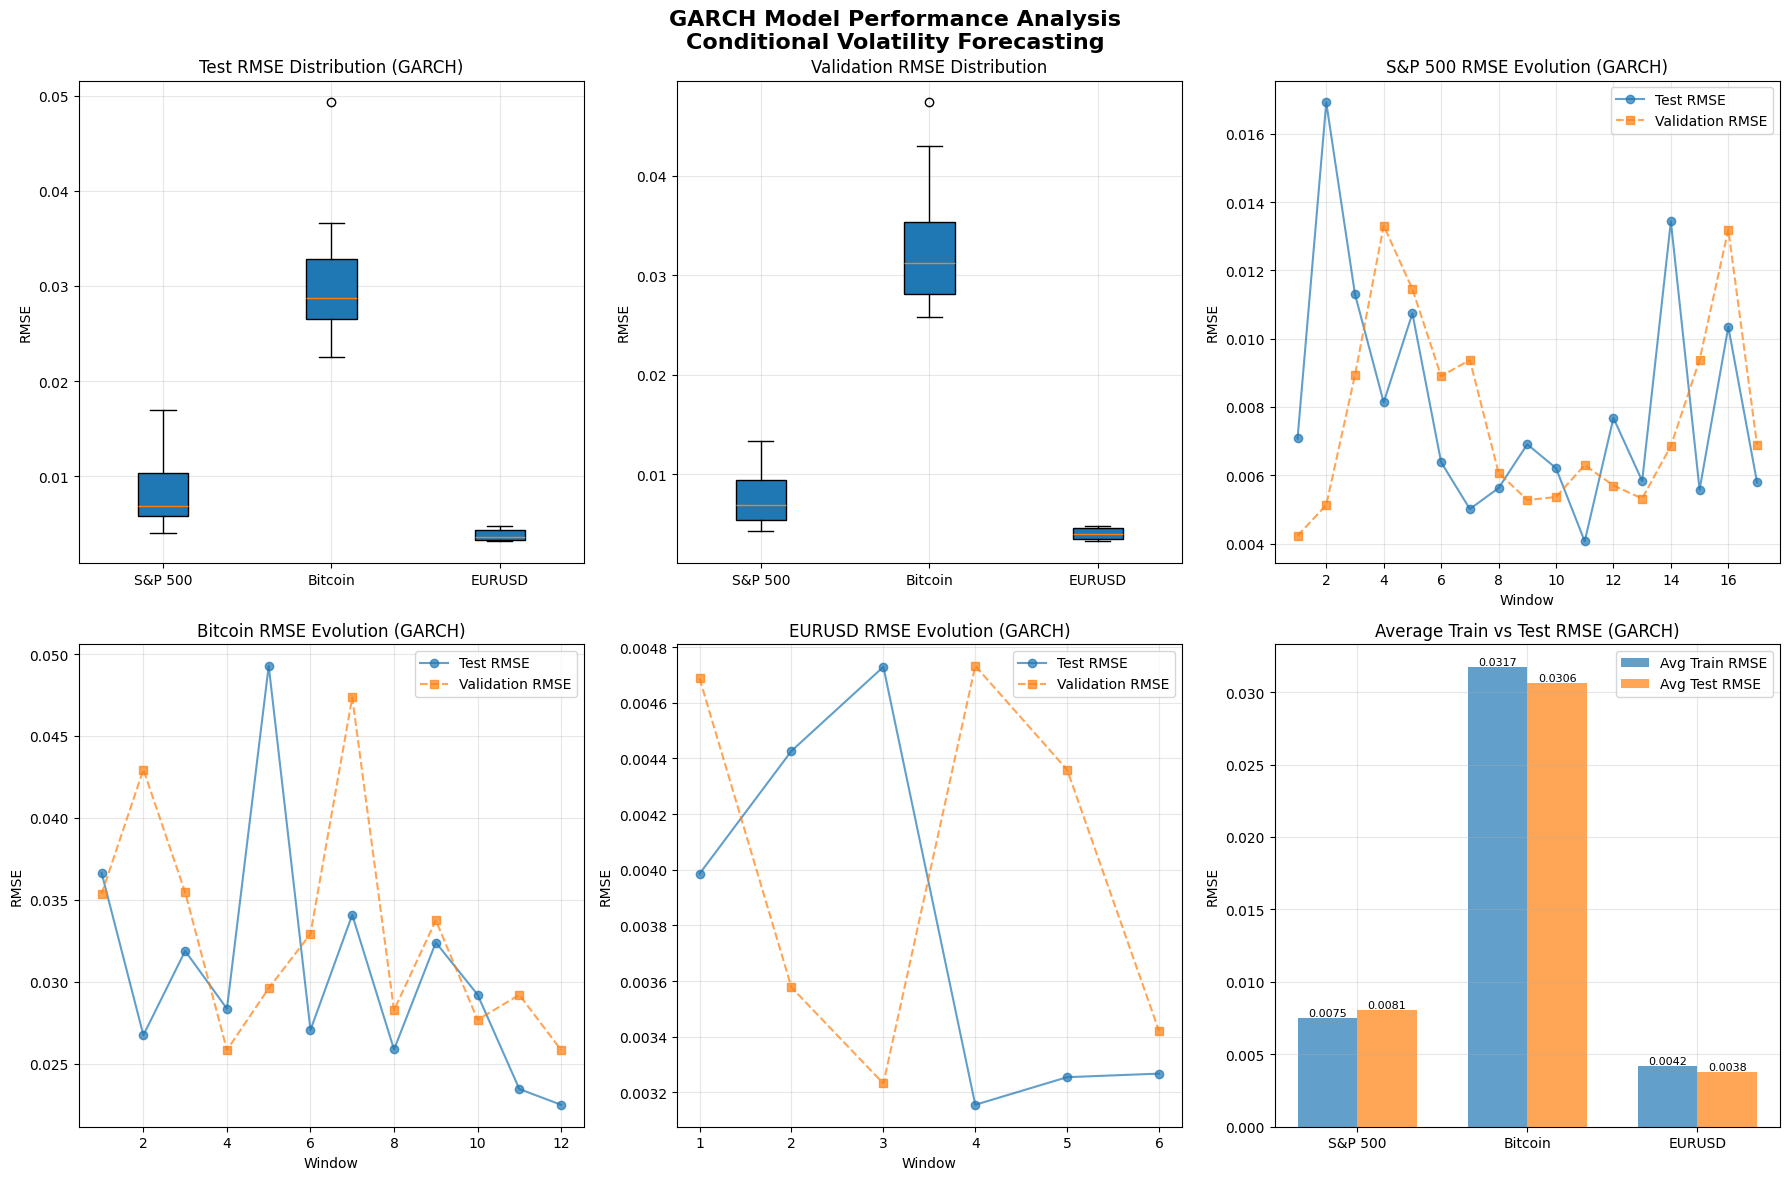


COMPREHENSIVE GARCH ANALYSIS RESULTS

📊 OVERALL PERFORMANCE SUMMARY (GARCH)
--------------------------------------------------
  Asset  Total_Windows  Avg_Train_RMSE  Avg_Validation_RMSE  Avg_Test_RMSE  Avg_Test_MAE Most_Common_Model
S&P 500             17        0.007509             0.007745       0.008059      0.006284       GARCH(1, 1)
Bitcoin             12        0.031739             0.032845       0.030616      0.024479       GARCH(1, 2)
 EURUSD              6        0.004186             0.004002       0.003803      0.003130       GARCH(1, 1)

📈 S&P 500 GARCH DETAILED RESULTS (17 windows)
--------------------------------------------------
 Window  Best_Order         AIC  Validation_RMSE  Train_RMSE  Train_MAE  Test_RMSE  Test_MAE
      1 GARCH(2, 1) 2194.967951         0.004228    0.007584   0.006015   0.007076  0.005663
      2 GARCH(1, 1) 1745.589151         0.005128    0.005187   0.004267   0.016915  0.012405
      3 GARCH(2, 2) 1503.406879         0.008931    0.004366   0.00

In [307]:
# Assuming you already ran:
# garch_results_sp = run_garch_cross_validation(sp500_cv_splits, sp500_clean, 'S&P 500')
# garch_results_btc = run_garch_cross_validation(bitcoin_cv_splits, bitcoin_clean, 'Bitcoin')
# garch_results_eur = run_garch_cross_validation(eurusd_cv_splits, eurusd_clean, 'EURUSD')


garch_summary_df = create_garch_results_summary(garch_results_sp, garch_results_btc,garch_results_eur)
fig_garch = plot_garch_performance_analysis(garch_results_sp, garch_results_btc,garch_results_eur)
plt.show()

create_garch_results_summary(garch_results_sp, garch_results_btc,garch_results_eur)

print("✅ Successfully implemented IC-based GARCH methodology")
print(f"✅ Processed {len(sp500_cv_splits) + len(bitcoin_cv_splits) + len(eurusd_cv_splits)} total cross-validation windows (GARCH)")


In [285]:
# # Fit GARCH models for both datasets
# print("\n=== Fitting GARCH Models ===")
# print("\nFitting GARCH(1,1) for S&P 500...")
# sp500_garch = fit_garch_model(sp500_clean['Log_Returns'])
# print(sp500_garch.summary())

# print("\n" + "="*80)
# print("\nFitting GARCH(1,1) for Bitcoin...")
# bitcoin_garch = fit_garch_model(bitcoin_clean['Log_Returns'])
# print(bitcoin_garch.summary())

# print("\n" + "="*80)
# print("\nFitting GARCH(1,1) for EURUSD...")
# eurusd_garch = fit_garch_model(eurusd_clean['Log_Returns'])
# print(eurusd_garch.summary())

In [286]:
# Extract GARCH conditional volatility
sp500_clean['GARCH_Volatility'] = get_garch_volatility(sp500_garch, sp500_clean['Log_Returns'])
bitcoin_clean['GARCH_Volatility'] = get_garch_volatility(bitcoin_garch, bitcoin_clean['Log_Returns'])
eurusd_clean['GARCH_Volatility'] = get_garch_volatility(eurusd_garch, eurusd_clean['Log_Returns'])

print("\n=== GARCH Volatility Statistics ===")
print(f"S&P 500 GARCH Volatility - Mean: {sp500_clean['GARCH_Volatility'].mean():.6f}, Std: {sp500_clean['GARCH_Volatility'].std():.6f}")
print(f"Bitcoin GARCH Volatility - Mean: {bitcoin_clean['GARCH_Volatility'].mean():.6f}, Std: {bitcoin_clean['GARCH_Volatility'].std():.6f}")
print(f"EURUSD GARCH Volatility - Mean: {eurusd_clean['GARCH_Volatility'].mean():.6f}, Std: {eurusd_clean['GARCH_Volatility'].std():.6f}")


=== GARCH Volatility Statistics ===
S&P 500 GARCH Volatility - Mean: 0.010440, Std: 0.006176
Bitcoin GARCH Volatility - Mean: 0.036201, Std: 0.014206
EURUSD GARCH Volatility - Mean: 0.005608, Std: 0.001440


## 3. LSTM Model Implementation

We'll create LSTM networks that use GARCH volatility predictions as input features to predict future volatility.

In [ ]:
def create_lstm_sequences(data, lookback=60):
    """
    Create sequences for LSTM training
    
    Parameters:
    data: array of values to create sequences from
    lookback: number of time steps to look back
    
    Returns:
    X: input sequences
    y: target values
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_lstm_model(lookback, units=50, dropout=0.2):
    """
    Build LSTM model architecture
    """
    model = Sequential()
    
    # First LSTM layer with return sequences
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, 1)))
    model.add(Dropout(dropout))
    
    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    
    # Third LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
def prepare_garch_lstm_data(data, train_split=0.8, lookback=60):
    """
    Prepare data for GARCH-LSTM hybrid model
    """
    # Use GARCH volatility as input feature
    garch_vol = data['GARCH_Volatility'].values.reshape(-1, 1)
    realized_vol = data['Realized_Volatility'].values.reshape(-1, 1)
    
    # Scale the data
    scaler_garch = MinMaxScaler(feature_range=(0, 1))
    scaler_realized = MinMaxScaler(feature_range=(0, 1))
    
    garch_vol_scaled = scaler_garch.fit_transform(garch_vol)
    realized_vol_scaled = scaler_realized.fit_transform(realized_vol)
    
    # Create sequences
    X, y = create_lstm_sequences(garch_vol_scaled, lookback)
    
    # Split into train and test
    train_size = int(len(X) * train_split)
    
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Get corresponding realized volatility for comparison
    y_realized_train = realized_vol_scaled[lookback:lookback+train_size]
    y_realized_test = realized_vol_scaled[lookback+train_size:]
    
    return X_train, X_test, y_train, y_test, y_realized_train, y_realized_test, scaler_garch, scaler_realized

# LSTM CV Implementation

In [287]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

def create_lstm_sequences_multifeature(features, target, lookback=60):
    """
    Create sequences for (possibly multi-feature) LSTM training.
    
    features : np.array of shape (T, n_features)
    target   : np.array of shape (T,) or (T, 1) – here: realized volatility
    """
    if target.ndim == 2:
        target = target.flatten()
        
    X, y = [], []
    for i in range(lookback, len(target)):
        X.append(features[i-lookback:i, :])   # (lookback, n_features)
        y.append(target[i])                   # scalar
    return np.array(X), np.array(y)


def build_lstm_model(lookback, n_features=1, units=50, dropout=0.2):
    """
    Build LSTM model architecture that supports multi-feature input.
    
    input_shape = (lookback, n_features)
    """
    model = Sequential()
    
    # First LSTM layer with return sequences
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, n_features)))
    model.add(Dropout(dropout))
    
    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    
    # Third LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    
    # Output layer: predict realized volatility (scalar)
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [288]:
def prepare_garch_lstm_data_for_window(split, garch_window_result, lookback=60):
    """
    Prepare GARCH-LSTM data for a single CV window.
    
    - Features: [Realized_Volatility, GARCH_Volatility]
    - Target:   Realized_Volatility
    - Train/Test split consistent with the CV window (train vs test dates)
    
    Returns:
    X_train, X_test, y_train, y_test (scaled),
    y_real_train_orig, y_real_test_orig (in original scale),
    scaler_X, scaler_y
    """
    # --- 1. Build full return series for this window (train + test) ---
    train_returns = split['train']['data']['Log_Returns']
    test_returns  = split['test']['data']['Log_Returns']
    
    returns_full = pd.concat([train_returns, test_returns])
    n_train = len(train_returns)
    n_test  = len(test_returns)
    T = n_train + n_test
    
    # Realized volatility (you can change to squared returns if you want)
    realized_vol_full = np.abs(returns_full.values)  # shape (T,)
    
    # --- 2. GARCH volatility for this window ---
    # From GARCH CV results:
    train_garch_vol = garch_window_result['train_cond_vol']          # index = train
    test_garch_vol  = garch_window_result['test_forecast_vol']       # index = test
    
    garch_vol_full = pd.concat([train_garch_vol, test_garch_vol])
    # Re-align to ensure correct order vs returns_full
    garch_vol_full = garch_vol_full.loc[returns_full.index].values   # shape (T,)
    
    # --- 3. Build feature matrix: [Realized_Vol, GARCH_Vol] ---
    features_full = np.column_stack([realized_vol_full, garch_vol_full])  # (T, 2)
    
    # --- 4. Scaling (keep similar to your previous approach) ---
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    X_scaled = scaler_X.fit_transform(features_full)
    y_scaled = scaler_y.fit_transform(realized_vol_full.reshape(-1, 1)).flatten()
    
    # --- 5. Create sequences for the full window ---
    X_seq, y_seq = create_lstm_sequences_multifeature(X_scaled, y_scaled, lookback=lookback)
    # sequences indices map to target indices: target_index = lookback .. T-1
    N_seq = len(y_seq)
    
    # --- 6. Split sequences into train/test based on time index ---
    # A sequence with target at index i is train if i < n_train
    # target_index for sequence j is: lookback + j
    # So train sequences are j = 0 .. (n_train - lookback - 1)
    n_train_seq = max(0, n_train - lookback)
    
    X_train = X_seq[:n_train_seq]
    y_train = y_seq[:n_train_seq]
    X_test  = X_seq[n_train_seq:]
    y_test  = y_seq[n_train_seq:]
    
    # --- 7. For evaluation in original scale, grab corresponding realized vol ---
    # Indices in target space:
    target_indices = np.arange(lookback, T)   # length N_seq
    
    train_target_idx = target_indices[:n_train_seq]
    test_target_idx  = target_indices[n_train_seq:]
    
    y_real_train_orig = realized_vol_full[train_target_idx]
    y_real_test_orig  = realized_vol_full[test_target_idx]
    
    return (X_train, X_test, y_train, y_test, 
            y_real_train_orig, y_real_test_orig,
            scaler_X, scaler_y)


In [293]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_garch_lstm_cross_validation(cv_splits, garch_results, data_clean, asset_name,
                                    lookback=60, units=50, dropout=0.2,
                                    epochs=50, batch_size=32, verbose=1):
    """
    GARCH-LSTM hybrid cross-validation:
    - For each CV window:
      * use GARCH train_cond_vol + test_forecast_vol
      * build features [Realized_Vol, GARCH_Vol]
      * train LSTM on train part, evaluate on test part
    
    Parameters
    ----------
    cv_splits    : list of CV windows (create_sp500_cv_splits, etc.)
    garch_results: dict from run_garch_cross_validation(...)
    data_clean   : full cleaned DataFrame (for compatibility, not heavily used here)
    asset_name   : str
    lookback     : int
    units, dropout, epochs, batch_size: LSTM hyperparameters
    
    Returns
    -------
    dict with:
      - 'asset_name'
      - 'all_results': per-window details
      - 'summary_df' : window-level metrics
      - 'performance_summary'
    """
    print(f"\n=== {asset_name.upper()} GARCH-LSTM CROSS-VALIDATION ===")
    print(f"Lookback: {lookback} | Epochs: {epochs} | Batch size: {batch_size}")
    print("-" * 80)
    
    all_results = []
    summary_rows = []
    
    garch_window_results = {w['window_id']: w for w in garch_results['all_results']}
    
    for split in cv_splits:
        window_id = split['window_id']
        print(f"\n🔄 Processing Window {window_id}/{len(cv_splits)}...")
        
        if window_id not in garch_window_results:
            print(f"   ❌ No GARCH results found for Window {window_id}, skipping.")
            continue
        
        garch_w = garch_window_results[window_id]
        
        # --- Prepare data ---
        (X_train, X_test, y_train, y_test,
         y_real_train_orig, y_real_test_orig,
         scaler_X, scaler_y) = prepare_garch_lstm_data_for_window(
            split, garch_w, lookback=lookback
        )
        
        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            print(f"   ⚠️ Not enough sequence data for LSTM in Window {window_id}, skipping.")
            continue
        
        n_features = X_train.shape[2]
        print(f"   Train sequences: {X_train.shape[0]} | Test sequences: {X_test.shape[0]} | Features: {n_features}")
        
        # --- Build and train model ---
        model = build_lstm_model(lookback=lookback, n_features=n_features,
                                 units=units, dropout=dropout)

        if verbose:
            print(model.summary())
        
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=verbose
        )
        
        # --- Predictions & metrics ---
        y_pred_test_scaled = model.predict(X_test).flatten()
        y_pred_test_orig = scaler_y.inverse_transform(
            y_pred_test_scaled.reshape(-1, 1)
        ).flatten()
        
        # RMSE / MAE on realized volatility in original scale
        test_rmse = np.sqrt(mean_squared_error(y_real_test_orig, y_pred_test_orig))
        test_mae = mean_absolute_error(y_real_test_orig, y_pred_test_orig)
        
        print(f"   ✅ Test RMSE (realized vol) = {test_rmse:.6f}, Test MAE = {test_mae:.6f}")
        
        # Store per-window result
        window_result = {
            'window_id': window_id,
            'asset': asset_name,
            'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} "
                            f"to {split['train']['end'].strftime('%Y-%m-%d')}",
            'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} "
                           f"to {split['test']['end'].strftime('%Y-%m-%d')}",
            'train_size_obs': split['train']['size'],
            'test_size_obs': split['test']['size'],
            'train_size_seq': X_train.shape[0],
            'test_size_seq': X_test.shape[0],
            'garch_order': garch_w['best_order'],
            'garch_ic_value': garch_w['best_ic_value'],
            'lookback': lookback,
            'lstm_units': units,
            'lstm_dropout': dropout,
            'metrics': {
                'test_rmse_realized_vol': test_rmse,
                'test_mae_realized_vol': test_mae
            },
            'model': model,
            'history': history.history,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y
        }
        
        all_results.append(window_result)
        
        summary_rows.append({
            'Window': window_id,
            'GARCH_Order': f"GARCH{garch_w['best_order']}",
            'Lookback': lookback,
            'Train_Seq': X_train.shape[0],
            'Test_Seq': X_test.shape[0],
            'Test_RMSE_RealVol': test_rmse,
            'Test_MAE_RealVol': test_mae
        })
    
    summary_df = pd.DataFrame(summary_rows).sort_values('Window')
    
    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse_realvol': summary_df['Test_RMSE_RealVol'].mean(),
            'std_test_rmse_realvol': summary_df['Test_RMSE_RealVol'].std(),
            'avg_test_mae_realvol': summary_df['Test_MAE_RealVol'].mean(),
            'std_test_mae_realvol': summary_df['Test_MAE_RealVol'].std()
        }
    else:
        performance_summary = None
    
    print("\n" + "="*80)
    print(f"{asset_name.upper()} GARCH-LSTM CROSS-VALIDATION COMPLETE")
    print("="*80)
    if performance_summary:
        print(f"✅ Successfully processed {performance_summary['successful_windows']}/"
              f"{performance_summary['total_windows']} windows")
        print(f"📊 Avg Test RMSE (realized vol): "
              f"{performance_summary['avg_test_rmse_realvol']:.6f} "
              f"± {performance_summary['std_test_rmse_realvol']:.6f}")
        print(f"📊 Avg Test MAE (realized vol): "
              f"{performance_summary['avg_test_mae_realvol']:.6f} "
              f"± {performance_summary['std_test_mae_realvol']:.6f}")
    else:
        print("❌ No successful GARCH-LSTM windows.")
    
    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'approach': 'GARCH-LSTM hybrid with CV windows',
            'features': '[Realized Volatility, GARCH Conditional Volatility]',
            'target': 'Realized Volatility',
            'lookback': lookback,
            'lstm_architecture': '3-layer LSTM + Dense(1)',
            'garch_results_source': 'run_garch_cross_validation outputs'
        }
    }


## 4. Train GARCH-LSTM Hybrid Models

In [ ]:
# # Prepare data for S&P 500
# print("\n=== Preparing S&P 500 Data for GARCH-LSTM ===")
# lookback = 60
# X_train_sp, X_test_sp, y_train_sp, y_test_sp, y_real_train_sp, y_real_test_sp, scaler_garch_sp, scaler_real_sp = prepare_garch_lstm_data(
#     sp500_clean, train_split=0.8, lookback=lookback
# )

# print(f"Training set size: {X_train_sp.shape[0]}")
# print(f"Test set size: {X_test_sp.shape[0]}")
# print(f"Lookback period: {lookback} days")

# # Build and train S&P 500 model
# print("\n=== Training S&P 500 GARCH-LSTM Model ===")
# model_sp = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
# print(model_sp.summary())

# history_sp = model_sp.fit(
#     X_train_sp, y_train_sp,
#     epochs=50,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1
# )

lookback = 20

garch_lstm_sp = run_garch_lstm_cross_validation(
    sp500_cv_splits,
    garch_results_sp,
    sp500_clean,
    asset_name='S&P 500',
    lookback=lookback,
    units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)


=== S&P 500 GARCH-LSTM CROSS-VALIDATION ===
Lookback: 20 | Epochs: 50 | Batch size: 32
--------------------------------------------------------------------------------

🔄 Processing Window 1/17...
   Train sequences: 735 | Test sequences: 252 | Features: 2


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                  │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0223 - val_loss: 0.0063
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0199 - val_loss: 0.0060
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0202 - val_loss: 0.0071
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0194 - val_loss: 0.0077
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0198 - val_loss: 0.0073
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0200 - val_loss: 0.0073
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0196 - val_loss: 0.0073
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0197 - val_loss: 0.0069
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0196 - val_loss: 0.0070
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0201 - val_loss: 0.0071
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0188 - val_loss: 0.0066
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                  │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_87 (LSTM)                  │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_88 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0130 - val_loss: 0.0337
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0125 - val_loss: 0.0331
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0123 - val_loss: 0.0337
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0120 - val_loss: 0.0337
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0116 - val_loss: 0.0336
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0113 - val_loss: 0.0334
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0113 - val_loss: 0.0333
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0113 - val_loss: 0.0330
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0116 - val_loss: 0.0333
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0112 - val_loss: 0.0329
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0115 - val_loss: 0.0332
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_93 (LSTM)                  │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0048 - val_loss: 0.0664
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0039 - val_loss: 0.0620
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0038 - val_loss: 0.0618
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0038 - val_loss: 0.0619
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0610
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0036 - val_loss: 0.0599
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037 - val_loss: 0.0595
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - val_loss: 0.0590
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036 - val_loss: 0.0590
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0037 - val_loss: 0.0597
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036 - val_loss: 0.0587
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_96 (LSTM)                  │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_97 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_98 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0169 - val_loss: 0.0040
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0137 - val_loss: 0.0036
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0130 - val_loss: 0.0036
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0133 - val_loss: 0.0035
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0139 - val_loss: 0.0039
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0138 - val_loss: 0.0040
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0140 - val_loss: 0.0039
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0140 - val_loss: 0.0041
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0139 - val_loss: 0.0041
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0130 - val_loss: 0.0037
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0133 - val_loss: 0.0040
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_99 (LSTM)                  │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_100 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_101 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0204 - val_loss: 0.0033
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0158 - val_loss: 0.0028
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0153 - val_loss: 0.0027
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0154 - val_loss: 0.0029
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0153 - val_loss: 0.0029
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0153 - val_loss: 0.0031
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0151 - val_loss: 0.0033
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0154 - val_loss: 0.0029
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0143 - val_loss: 0.0027
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0155 - val_loss: 0.0031
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0147 - val_loss: 0.0028
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_102 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_103 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_104 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0245 - val_loss: 0.0226
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0169 - val_loss: 0.0228
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0169 - val_loss: 0.0222
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0167 - val_loss: 0.0225
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0169 - val_loss: 0.0228
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0167 - val_loss: 0.0230
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0166 - val_loss: 0.0223
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0163 - val_loss: 0.0225
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0160 - val_loss: 0.0225
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0162 - val_loss: 0.0223
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0163 - val_loss: 0.0222
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_105 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_106 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_107 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0187 - val_loss: 0.0069
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0128 - val_loss: 0.0069
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0129 - val_loss: 0.0070
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0124 - val_loss: 0.0072
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0128 - val_loss: 0.0070
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0131 - val_loss: 0.0068
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0128 - val_loss: 0.0068
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0127 - val_loss: 0.0068
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_108 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_109 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0152 - val_loss: 0.0037
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0119 - val_loss: 0.0037
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0115 - val_loss: 0.0037
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0112 - val_loss: 0.0037
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0115 - val_loss: 0.0037
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0111 - val_loss: 0.0037
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0108 - val_loss: 0.0037
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0110 - val_loss: 0.0037
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0107 - val_loss: 0.0037
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0110 - val_loss: 0.0037
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0113 - val_loss: 0.0037
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - los

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_111 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_112 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_113 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.0623 - val_loss: 0.0630
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0412 - val_loss: 0.0584
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0403 - val_loss: 0.0567
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0406 - val_loss: 0.0558
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0395 - val_loss: 0.0549
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0403 - val_loss: 0.0539
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0398 - val_loss: 0.0533
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0392 - val_loss: 0.0530
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0401 - val_loss: 0.0529
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0406 - val_loss: 0.0526
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0393 - val_loss: 0.0523
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - los

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_114 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_115 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_116 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0187 - val_loss: 0.0172
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0136 - val_loss: 0.0177
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0131 - val_loss: 0.0174
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0127 - val_loss: 0.0176
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0129 - val_loss: 0.0180
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0130 - val_loss: 0.0187
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0126 - val_loss: 0.0183
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0126 - val_loss: 0.0185
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0126 - val_loss: 0.0189
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0131 - val_loss: 0.0183
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0126 - val_loss: 0.0188
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_117 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_118 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0303 - val_loss: 0.0084
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0246 - val_loss: 0.0086
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0249 - val_loss: 0.0090
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0248 - val_loss: 0.0091
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0249 - val_loss: 0.0092
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0245 - val_loss: 0.0094
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0247 - val_loss: 0.0094
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0242 - val_loss: 0.0096
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0242 - val_loss: 0.0095
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0244 - val_loss: 0.0096
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0237 - val_loss: 0.0094
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_120 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_121 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_122 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0023 - val_loss: 5.6662e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 5.1140e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 4.4484e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 4.9296e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020 - val_loss: 4.0867e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 4.1410e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 4.6843e-04
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - val_loss: 4.7692e-04
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019 - val_loss: 5.0317e-04
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 3.8889e-04
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 4.2957e-04
Epoch 12/50
21

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_123 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_124 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_125 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0123 - val_loss: 0.0444
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - val_loss: 0.0457
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - val_loss: 0.0448
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0107 - val_loss: 0.0439
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0107 - val_loss: 0.0421
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0108 - val_loss: 0.0420
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0108 - val_loss: 0.0413
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0107 - val_loss: 0.0415
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0105 - val_loss: 0.0414
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0110 - val_loss: 0.0416
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0108 - val_loss: 0.0417
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_126 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_127 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_128 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0151 - val_loss: 0.0053
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0127 - val_loss: 0.0055
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0128 - val_loss: 0.0055
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0128 - val_loss: 0.0053
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0124 - val_loss: 0.0053
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0126 - val_loss: 0.0052
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0125 - val_loss: 0.0052
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0124 - val_loss: 0.0051
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0126 - val_loss: 0.0051
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0124 - val_loss: 0.0051
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0121 - val_loss: 0.0050
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_129 (LSTM)                 │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_131 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0122 - val_loss: 0.0026
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0088 - val_loss: 0.0025
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0086 - val_loss: 0.0025
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0087 - val_loss: 0.0025
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0083 - val_loss: 0.0025
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0080 - val_loss: 0.0025
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0078 - val_loss: 0.0026
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss

In [294]:
# # Prepare data for Bitcoin
# print("\n=== Preparing Bitcoin Data for GARCH-LSTM ===")
# X_train_btc, X_test_btc, y_train_btc, y_test_btc, y_real_train_btc, y_real_test_btc, scaler_garch_btc, scaler_real_btc = prepare_garch_lstm_data(
#     bitcoin_clean, train_split=0.8, lookback=lookback
# )

# print(f"Training set size: {X_train_btc.shape[0]}")
# print(f"Test set size: {X_test_btc.shape[0]}")
# print(f"Lookback period: {lookback} days")

# # Build and train Bitcoin model
# print("\n=== Training Bitcoin GARCH-LSTM Model ===")
# model_btc = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
# print(model_btc.summary())

# history_btc = model_btc.fit(
#     X_train_btc, y_train_btc,
#     epochs=50,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1
# )

lookback = 30

garch_lstm_btc = run_garch_lstm_cross_validation(
    bitcoin_cv_splits,
    garch_results_btc,
    bitcoin_clean,
    asset_name='Bitcoin',
    lookback=lookback,
    units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)



=== BITCOIN GARCH-LSTM CROSS-VALIDATION ===
Lookback: 30 | Epochs: 50 | Batch size: 32
--------------------------------------------------------------------------------

🔄 Processing Window 1/12...
   Train sequences: 700 | Test sequences: 181 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
   ✅ Test RMSE (realized vol) = 0.034935, Test MAE = 0.024326

🔄 Processing Window 2/12...
   Train sequences: 701 | Test sequences: 184 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
   ✅ Test RMSE (realized vol) = 0.024612, Test MAE = 0.016297

🔄 Processing Window 3/12...
   Train sequences: 701 | Test sequences: 181 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
   ✅ Test RMSE (realized vol) = 0.026760, Test MAE = 0.018079

🔄 Processing Window 4/12...
   Train sequences: 700 | Test sequences: 184 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
   ✅ Test RMSE (realized vol) = 0.025171, Test MAE = 0.017345

🔄 Processing Window 5/12...
   Train sequences: 700 | Test sequences: 182 

In [295]:
# # Prepare data for EURUSD
# print("\n=== Preparing EURUSD Data for GARCH-LSTM ===")
# X_train_eurusd, X_test_eurusd, y_train_eurusd, y_test_eurusd, y_real_train_eurusd, y_real_test_eurusd, scaler_garch_eurusd, scaler_real_eurusd = prepare_garch_lstm_data(
#     eurusd_clean, train_split=0.8, lookback=lookback
# )

# print(f"Training set size: {X_train_eurusd.shape[0]}")
# print(f"Test set size: {X_test_eurusd.shape[0]}")
# print(f"Lookback period: {lookback} days")

# # Build and train EURUSD model
# print("\n=== Training EURUSD GARCH-LSTM Model ===")
# model_eurusd = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
# print(model_eurusd.summary())

# history_eurusd = model_eurusd.fit(
#     X_train_eurusd, y_train_eurusd,
#     epochs=50,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1
# )

garch_lstm_eur = run_garch_lstm_cross_validation(
    eurusd_cv_splits,
    garch_results_eur,
    eurusd_clean,
    asset_name='EURUSD',
    lookback=lookback,
    units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)


=== EURUSD GARCH-LSTM CROSS-VALIDATION ===
Lookback: 30 | Epochs: 50 | Batch size: 32
--------------------------------------------------------------------------------

🔄 Processing Window 1/6...
   Train sequences: 492 | Test sequences: 131 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
   ✅ Test RMSE (realized vol) = 0.003303, Test MAE = 0.002889

🔄 Processing Window 2/6...
   Train sequences: 492 | Test sequences: 132 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
   ✅ Test RMSE (realized vol) = 0.004240, Test MAE = 0.003114

🔄 Processing Window 3/6...
   Train sequences: 490 | Test sequences: 132 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
   ✅ Test RMSE (realized vol) = 0.004645, Test MAE = 0.003351

🔄 Processing Window 4/6...
   Train sequences: 489 | Test sequences: 131 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
   ✅ Test RMSE (realized vol) = 0.003146, Test MAE = 0.002314

🔄 Processing Window 5/6...
   Train sequences: 491 | Test sequences: 129 | F

## 5. Model Predictions and Performance Metrics

In [308]:
# # Make predictions for S&P 500
# print("\n=== Making Predictions for S&P 500 ===")
# y_pred_train_sp = model_sp.predict(X_train_sp)
# y_pred_test_sp = model_sp.predict(X_test_sp)

# # Inverse transform predictions to original scale
# y_pred_train_sp_orig = scaler_garch_sp.inverse_transform(y_pred_train_sp)
# y_pred_test_sp_orig = scaler_garch_sp.inverse_transform(y_pred_test_sp.reshape(-1, 1))
# y_train_sp_orig = scaler_garch_sp.inverse_transform(y_train_sp.reshape(-1, 1))
# y_test_sp_orig = scaler_garch_sp.inverse_transform(y_test_sp.reshape(-1, 1))

# # Get realized volatility for comparison
# y_real_train_sp_orig = scaler_real_sp.inverse_transform(y_real_train_sp)
# y_real_test_sp_orig = scaler_real_sp.inverse_transform(y_real_test_sp)

# # Calculate metrics for S&P 500
# rmse_train_sp = np.sqrt(mean_squared_error(y_real_train_sp_orig, y_pred_train_sp_orig))
# mae_train_sp = mean_absolute_error(y_real_train_sp_orig, y_pred_train_sp_orig)
# rmse_test_sp = np.sqrt(mean_squared_error(y_real_test_sp_orig, y_pred_test_sp_orig))
# mae_test_sp = mean_absolute_error(y_real_test_sp_orig, y_pred_test_sp_orig)

# # Calculate GARCH-only performance for comparison
# rmse_garch_train_sp = np.sqrt(mean_squared_error(y_real_train_sp_orig, y_train_sp_orig))
# mae_garch_train_sp = mean_absolute_error(y_real_train_sp_orig, y_train_sp_orig)
# rmse_garch_test_sp = np.sqrt(mean_squared_error(y_real_test_sp_orig, y_test_sp_orig))
# mae_garch_test_sp = mean_absolute_error(y_real_test_sp_orig, y_test_sp_orig)

# print("\n=== S&P 500 Performance Metrics ===")
# print("\nGARCH-LSTM Hybrid Model:")
# print(f"Training Set - RMSE: {rmse_train_sp:.8f}, MAE: {mae_train_sp:.8f}")
# print(f"Test Set - RMSE: {rmse_test_sp:.8f}, MAE: {mae_test_sp:.8f}")
# print("\nGARCH Model (Baseline):")
# print(f"Training Set - RMSE: {rmse_garch_train_sp:.8f}, MAE: {mae_garch_train_sp:.8f}")
# print(f"Test Set - RMSE: {rmse_garch_test_sp:.8f}, MAE: {mae_garch_test_sp:.8f}")
# print("\nImprovement over GARCH:")
# print(f"Test RMSE Improvement: {((rmse_garch_test_sp - rmse_test_sp) / rmse_garch_test_sp * 100):.2f}%")
# print(f"Test MAE Improvement: {((mae_garch_test_sp - mae_test_sp) / mae_garch_test_sp * 100):.2f}%")

In [309]:
# # Make predictions for Bitcoin
# print("\n=== Making Predictions for Bitcoin ===")
# y_pred_train_btc = model_btc.predict(X_train_btc)
# y_pred_test_btc = model_btc.predict(X_test_btc)

# # Inverse transform predictions to original scale
# y_pred_train_btc_orig = scaler_garch_btc.inverse_transform(y_pred_train_btc)
# y_pred_test_btc_orig = scaler_garch_btc.inverse_transform(y_pred_test_btc.reshape(-1, 1))
# y_train_btc_orig = scaler_garch_btc.inverse_transform(y_train_btc.reshape(-1, 1))
# y_test_btc_orig = scaler_garch_btc.inverse_transform(y_test_btc.reshape(-1, 1))

# # Get realized volatility for comparison
# y_real_train_btc_orig = scaler_real_btc.inverse_transform(y_real_train_btc)
# y_real_test_btc_orig = scaler_real_btc.inverse_transform(y_real_test_btc)

# # Calculate metrics for Bitcoin
# rmse_train_btc = np.sqrt(mean_squared_error(y_real_train_btc_orig, y_pred_train_btc_orig))
# mae_train_btc = mean_absolute_error(y_real_train_btc_orig, y_pred_train_btc_orig)
# rmse_test_btc = np.sqrt(mean_squared_error(y_real_test_btc_orig, y_pred_test_btc_orig))
# mae_test_btc = mean_absolute_error(y_real_test_btc_orig, y_pred_test_btc_orig)

# # Calculate GARCH-only performance for comparison
# rmse_garch_train_btc = np.sqrt(mean_squared_error(y_real_train_btc_orig, y_train_btc_orig))
# mae_garch_train_btc = mean_absolute_error(y_real_train_btc_orig, y_train_btc_orig)
# rmse_garch_test_btc = np.sqrt(mean_squared_error(y_real_test_btc_orig, y_test_btc_orig))
# mae_garch_test_btc = mean_absolute_error(y_real_test_btc_orig, y_test_btc_orig)

# print("\n=== Bitcoin Performance Metrics ===")
# print("\nGARCH-LSTM Hybrid Model:")
# print(f"Training Set - RMSE: {rmse_train_btc:.8f}, MAE: {mae_train_btc:.8f}")
# print(f"Test Set - RMSE: {rmse_test_btc:.8f}, MAE: {mae_test_btc:.8f}")
# print("\nGARCH Model (Baseline):")
# print(f"Training Set - RMSE: {rmse_garch_train_btc:.8f}, MAE: {mae_garch_train_btc:.8f}")
# print(f"Test Set - RMSE: {rmse_garch_test_btc:.8f}, MAE: {mae_garch_test_btc:.8f}")
# print("\nImprovement over GARCH:")
# print(f"Test RMSE Improvement: {((rmse_garch_test_btc - rmse_test_btc) / rmse_garch_test_btc * 100):.2f}%")
# print(f"Test MAE Improvement: {((mae_garch_test_btc - mae_test_btc) / mae_garch_test_btc * 100):.2f}%")

In [310]:
# # Make predictions for EURUSD
# print("\n=== Making Predictions for EURUSD ===")
# y_pred_train_eurusd = model_eurusd.predict(X_train_eurusd)
# y_pred_test_eurusd = model_eurusd.predict(X_test_eurusd)

# # Inverse transform predictions to original scale
# y_pred_train_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_pred_train_eurusd)
# y_pred_test_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_pred_test_eurusd.reshape(-1, 1))
# y_train_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_train_eurusd.reshape(-1, 1))
# y_test_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_test_eurusd.reshape(-1, 1))

# # Get realized volatility for comparison
# y_real_train_eurusd_orig = scaler_real_eurusd.inverse_transform(y_real_train_eurusd)
# y_real_test_eurusd_orig = scaler_real_eurusd.inverse_transform(y_real_test_eurusd)

# # Calculate metrics for Bitcoin
# rmse_train_eurusd = np.sqrt(mean_squared_error(y_real_train_eurusd_orig, y_pred_train_eurusd_orig))
# mae_train_eurusd = mean_absolute_error(y_real_train_eurusd_orig, y_pred_train_eurusd_orig)
# rmse_test_eurusd = np.sqrt(mean_squared_error(y_real_test_eurusd_orig, y_pred_test_eurusd_orig))
# mae_test_eurusd = mean_absolute_error(y_real_test_eurusd_orig, y_pred_test_eurusd_orig)

# # Calculate GARCH-only performance for comparison
# rmse_garch_train_eurusd = np.sqrt(mean_squared_error(y_real_train_eurusd_orig, y_train_eurusd_orig))
# mae_garch_train_eurusd = mean_absolute_error(y_real_train_eurusd_orig, y_train_eurusd_orig)
# rmse_garch_test_eurusd = np.sqrt(mean_squared_error(y_real_test_eurusd_orig, y_test_eurusd_orig))
# mae_garch_test_eurusd = mean_absolute_error(y_real_test_eurusd_orig, y_test_eurusd_orig)

# print("\n=== EURUSD Performance Metrics ===")
# print("\nGARCH-LSTM Hybrid Model:")
# print(f"Training Set - RMSE: {rmse_train_eurusd:.8f}, MAE: {mae_train_eurusd:.8f}")
# print(f"Test Set - RMSE: {rmse_test_eurusd:.8f}, MAE: {mae_test_eurusd:.8f}")
# print("\nGARCH Model (Baseline):")
# print(f"Training Set - RMSE: {rmse_garch_train_eurusd:.8f}, MAE: {mae_garch_train_eurusd:.8f}")
# print(f"Test Set - RMSE: {rmse_garch_test_eurusd:.8f}, MAE: {mae_garch_test_eurusd:.8f}")
# print("\nImprovement over GARCH:")
# print(f"Test RMSE Improvement: {((rmse_garch_test_eurusd - rmse_test_eurusd) / rmse_garch_test_eurusd * 100):.2f}%")
# print(f"Test MAE Improvement: {((mae_garch_test_eurusd - mae_test_eurusd) / mae_garch_test_eurusd * 100):.2f}%")

In [311]:
# print(garch_results_sp['performance_summary'])
# print(garch_results_btc['performance_summary'])
# print(garch_results_eur['performance_summary'])
# print(garch_lstm_sp['performance_summary'])
# print(garch_lstm_btc['performance_summary'])
# print(garch_lstm_eur['performance_summary'])

In [312]:
def compare_garch_vs_garch_lstm(garch_results, garch_lstm_results, asset_label="S&P 500"):
    """
    Compare baseline GARCH vs GARCH-LSTM hybrid using cross-validation summaries.
    
    Prints:
      - Average Test RMSE / MAE for both models
      - Percentage improvement of hybrid over GARCH
    """
    garch_ps = garch_results.get('performance_summary', None)
    hybrid_ps = garch_lstm_results.get('performance_summary', None)
    
    if garch_ps is None or hybrid_ps is None:
        print(f"\n❌ Missing performance summary for {asset_label}.")
        return
    
    # Baseline GARCH test metrics (averaged across windows)
    rmse_garch_test = garch_ps['avg_test_rmse']
    mae_garch_test  = garch_ps['avg_test_mae']
    
    # Hybrid GARCH-LSTM test metrics (averaged across windows)
    rmse_hybrid_test = hybrid_ps['avg_test_rmse_realvol']
    mae_hybrid_test  = hybrid_ps['avg_test_mae_realvol']
    
    # (Optional) you could also define proxy "train" metrics from summaries if needed,
    # but we focus on test performance like in the paper.
    
    print(f"\n=== {asset_label} Performance Metrics (Cross-Validation Averages) ===")
    
    print("\nGARCH-LSTM Hybrid Model (Averaged over windows):")
    print(f"Test Set - RMSE: {rmse_hybrid_test:.8f}, MAE: {mae_hybrid_test:.8f}")
    
    print("\nGARCH Model (Baseline, Averaged over windows):")
    print(f"Test Set - RMSE: {rmse_garch_test:.8f}, MAE: {mae_garch_test:.8f}")
    
    # Improvement (%)
    rmse_impr = (rmse_garch_test - rmse_hybrid_test) / rmse_garch_test * 100 if rmse_garch_test != 0 else 0.0
    mae_impr  = (mae_garch_test - mae_hybrid_test) / mae_garch_test * 100 if mae_garch_test != 0 else 0.0
    
    print("\nImprovement over GARCH (Test, Averages):")
    print(f"Test RMSE Improvement: {rmse_impr:.2f}%")
    print(f"Test MAE Improvement: {mae_impr:.2f}%")


In [313]:
compare_garch_vs_garch_lstm(garch_results_sp,  garch_lstm_sp,  asset_label="S&P 500")
compare_garch_vs_garch_lstm(garch_results_btc, garch_lstm_btc, asset_label="Bitcoin")
compare_garch_vs_garch_lstm(garch_results_eur, garch_lstm_eur, asset_label="EURUSD")



=== S&P 500 Performance Metrics (Cross-Validation Averages) ===

GARCH-LSTM Hybrid Model (Averaged over windows):
Test Set - RMSE: 0.00795243, MAE: 0.00571213

GARCH Model (Baseline, Averaged over windows):
Test Set - RMSE: 0.00805923, MAE: 0.00628437

Improvement over GARCH (Test, Averages):
Test RMSE Improvement: 1.33%
Test MAE Improvement: 9.11%

=== Bitcoin Performance Metrics (Cross-Validation Averages) ===

GARCH-LSTM Hybrid Model (Averaged over windows):
Test Set - RMSE: 0.02631924, MAE: 0.01824966

GARCH Model (Baseline, Averaged over windows):
Test Set - RMSE: 0.03061633, MAE: 0.02447866

Improvement over GARCH (Test, Averages):
Test RMSE Improvement: 14.04%
Test MAE Improvement: 25.45%

=== EURUSD Performance Metrics (Cross-Validation Averages) ===

GARCH-LSTM Hybrid Model (Averaged over windows):
Test Set - RMSE: 0.00350901, MAE: 0.00272804

GARCH Model (Baseline, Averaged over windows):
Test Set - RMSE: 0.00380335, MAE: 0.00312980

Improvement over GARCH (Test, Averages):


## 6. Visualizations

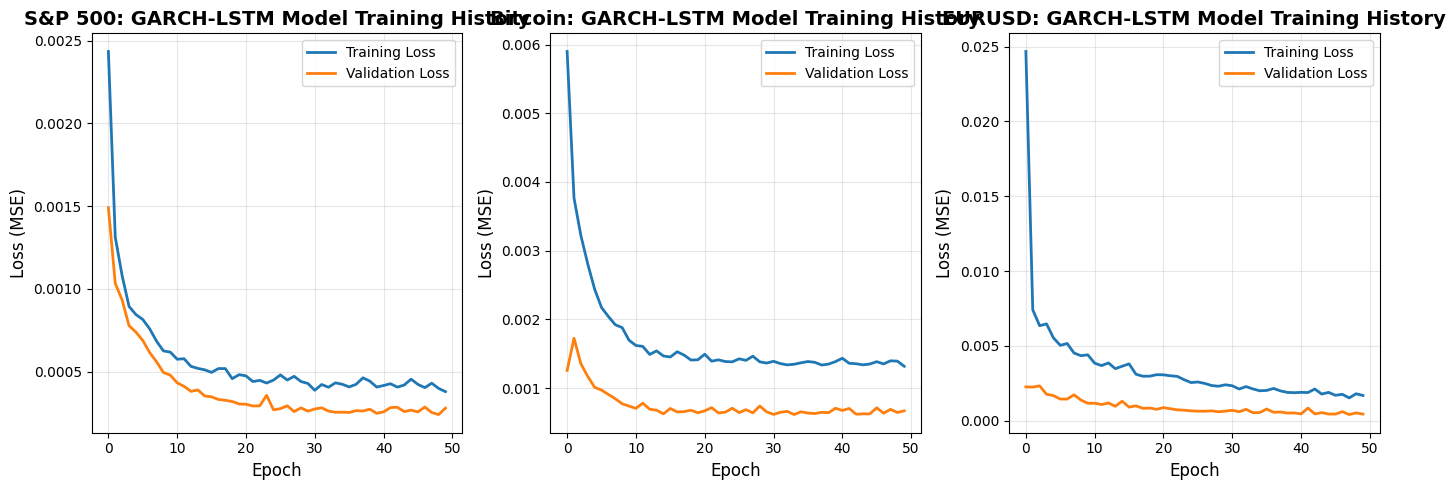

In [314]:
# Plot training history for S&P 500
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history_sp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_sp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('S&P 500: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Bitcoin: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history_eurusd.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eurusd.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('EURUSD: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)


plt.tight_layout()
# plt.savefig('garch_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Training history plot saved as 'garch_lstm_training_history.png'")

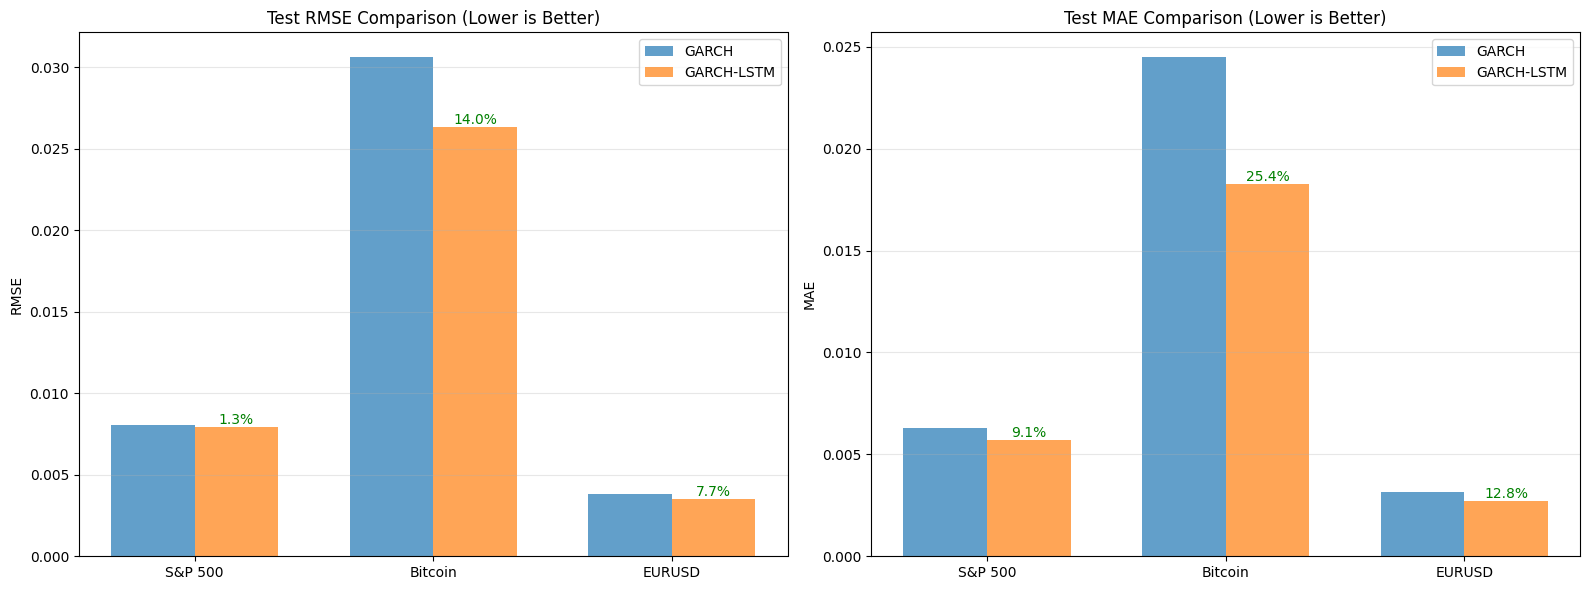

In [315]:
import matplotlib.pyplot as plt
import numpy as np

def plot_garch_vs_garch_lstm_bar(
    garch_results_sp, garch_results_btc, garch_results_eur,
    garch_lstm_sp, garch_lstm_btc, garch_lstm_eur
):
    """
    Creates bar plots comparing GARCH vs GARCH-LSTM Test RMSE and MAE
    across S&P 500, Bitcoin, and EURUSD.
    """

    # ----------------------
    # Extract metrics
    # ----------------------
    datasets = ["S&P 500", "Bitcoin", "EURUSD"]

    garch_rmse = [
        garch_results_sp['performance_summary']['avg_test_rmse'],
        garch_results_btc['performance_summary']['avg_test_rmse'],
        garch_results_eur['performance_summary']['avg_test_rmse']
    ]

    garch_mae = [
        garch_results_sp['performance_summary']['avg_test_mae'],
        garch_results_btc['performance_summary']['avg_test_mae'],
        garch_results_eur['performance_summary']['avg_test_mae']
    ]

    hybrid_rmse = [
        garch_lstm_sp['performance_summary']['avg_test_rmse_realvol'],
        garch_lstm_btc['performance_summary']['avg_test_rmse_realvol'],
        garch_lstm_eur['performance_summary']['avg_test_rmse_realvol']
    ]

    hybrid_mae = [
        garch_lstm_sp['performance_summary']['avg_test_mae_realvol'],
        garch_lstm_btc['performance_summary']['avg_test_mae_realvol'],
        garch_lstm_eur['performance_summary']['avg_test_mae_realvol']
    ]

    # Percentage improvement
    rmse_improvement = [(g - h) / g * 100 for g, h in zip(garch_rmse, hybrid_rmse)]
    mae_improvement  = [(g - h) / g * 100 for g, h in zip(garch_mae, hybrid_mae)]

    x = np.arange(len(datasets))
    width = 0.35  # bar width

    # ----------------------
    # Plot Test RMSE
    # ----------------------
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    ax0 = ax[0]
    bars1 = ax0.bar(x - width/2, garch_rmse, width, label='GARCH', alpha=0.7)
    bars2 = ax0.bar(x + width/2, hybrid_rmse, width, label='GARCH-LSTM', alpha=0.7)

    ax0.set_title("Test RMSE Comparison (Lower is Better)")
    ax0.set_xticks(x)
    ax0.set_xticklabels(datasets)
    ax0.set_ylabel("RMSE")
    ax0.legend()
    ax0.grid(axis='y', alpha=0.3)

    # Annotate improvements
    for i in range(len(x)):
        ax0.text(x[i] + width/2, hybrid_rmse[i], f"{rmse_improvement[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=10, color='green')

    # ----------------------
    # Plot Test MAE
    # ----------------------
    ax1 = ax[1]
    bars3 = ax1.bar(x - width/2, garch_mae, width, label='GARCH', alpha=0.7)
    bars4 = ax1.bar(x + width/2, hybrid_mae, width, label='GARCH-LSTM', alpha=0.7)

    ax1.set_title("Test MAE Comparison (Lower is Better)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets)
    ax1.set_ylabel("MAE")
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Annotate improvements
    for i in range(len(x)):
        ax1.text(x[i] + width/2, hybrid_mae[i], f"{mae_improvement[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=10, color='green')

    plt.tight_layout()
    plt.show()

plot_garch_vs_garch_lstm_bar(
    garch_results_sp, garch_results_btc, garch_results_eur,
    garch_lstm_sp, garch_lstm_btc, garch_lstm_eur
)

In [317]:
# # Plot predictions vs actual for S&P 500
# plt.figure(figsize=(20, 20))

# # S&P 500 - Full Period
# plt.subplot(5, 2, 1)
# plt.plot(y_real_test_sp_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
# plt.plot(y_pred_test_sp_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
# plt.plot(y_test_sp_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
# plt.title('S&P 500: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
# plt.xlabel('Time Index', fontsize=10)
# plt.ylabel('Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# # S&P 500 - Zoomed (first 200 points)
# plt.subplot(5, 2, 2)
# zoom_points = min(200, len(y_real_test_sp_orig))
# plt.plot(y_real_test_sp_orig[:zoom_points], label='Realized Volatility', alpha=0.7, linewidth=2)
# plt.plot(y_pred_test_sp_orig[:zoom_points], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
# plt.plot(y_test_sp_orig[:zoom_points], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
# plt.title(f'S&P 500: Volatility Predictions (Test Set - First {zoom_points} Points)', fontsize=12, fontweight='bold')
# plt.xlabel('Time Index', fontsize=10)
# plt.ylabel('Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# # Bitcoin - Full Period
# plt.subplot(5, 2, 3)
# plt.plot(y_real_test_btc_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
# plt.plot(y_pred_test_btc_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
# plt.plot(y_test_btc_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
# plt.title('Bitcoin: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
# plt.xlabel('Time Index', fontsize=10)
# plt.ylabel('Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# # Bitcoin - Zoomed (first 200 points)
# plt.subplot(5, 2, 4)
# zoom_points_btc = min(200, len(y_real_test_btc_orig))
# plt.plot(y_real_test_btc_orig[:zoom_points_btc], label='Realized Volatility', alpha=0.7, linewidth=2)
# plt.plot(y_pred_test_btc_orig[:zoom_points_btc], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
# plt.plot(y_test_btc_orig[:zoom_points_btc], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
# plt.title(f'Bitcoin: Volatility Predictions (Test Set - First {zoom_points_btc} Points)', fontsize=12, fontweight='bold')
# plt.xlabel('Time Index', fontsize=10)
# plt.ylabel('Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# # EURUSD - Full Period
# plt.subplot(5, 2, 5)
# plt.plot(y_real_test_eurusd_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
# plt.plot(y_pred_test_eurusd_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
# plt.plot(y_test_eurusd_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
# plt.title('EURUSD: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
# plt.xlabel('Time Index', fontsize=10)
# plt.ylabel('Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# # EURUSD - Zoomed (first 200 points)
# plt.subplot(5, 2, 6)
# zoom_points_eurusd = min(200, len(y_real_test_eurusd_orig))
# plt.plot(y_real_test_eurusd_orig[:zoom_points_eurusd], label='Realized Volatility', alpha=0.7, linewidth=2)
# plt.plot(y_pred_test_eurusd_orig[:zoom_points_eurusd], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
# plt.plot(y_test_eurusd_orig[:zoom_points_eurusd], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
# plt.title(f'EURUSD: Volatility Predictions (Test Set - First {zoom_points_eurusd} Points)', fontsize=12, fontweight='bold')
# plt.xlabel('Time Index', fontsize=10)
# plt.ylabel('Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# # S&P 500 Scatter Plot
# plt.subplot(5, 2, 7)
# plt.scatter(y_real_test_sp_orig, y_pred_test_sp_orig, alpha=0.5, s=10, label='GARCH-LSTM')
# plt.scatter(y_real_test_sp_orig, y_test_sp_orig, alpha=0.5, s=10, label='GARCH', color='orange')
# min_val = min(y_real_test_sp_orig.min(), y_pred_test_sp_orig.min())
# max_val = max(y_real_test_sp_orig.max(), y_pred_test_sp_orig.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
# plt.title('S&P 500: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
# plt.xlabel('Realized Volatility', fontsize=10)
# plt.ylabel('Predicted Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# # Bitcoin Scatter Plot
# plt.subplot(5, 2, 8)
# plt.scatter(y_real_test_btc_orig, y_pred_test_btc_orig, alpha=0.5, s=10, label='GARCH-LSTM')
# plt.scatter(y_real_test_btc_orig, y_test_btc_orig, alpha=0.5, s=10, label='GARCH', color='orange')
# min_val_btc = min(y_real_test_btc_orig.min(), y_pred_test_btc_orig.min())
# max_val_btc = max(y_real_test_btc_orig.max(), y_pred_test_btc_orig.max())
# plt.plot([min_val_btc, max_val_btc], [min_val_btc, max_val_btc], 'r--', linewidth=2, label='Perfect Prediction')
# plt.title('Bitcoin: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
# plt.xlabel('Realized Volatility', fontsize=10)
# plt.ylabel('Predicted Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)

# plt.subplot(5, 2, 9)
# plt.scatter(y_real_test_eurusd_orig, y_pred_test_eurusd_orig, alpha=0.5, s=10, label='GARCH-LSTM')
# plt.scatter(y_real_test_eurusd_orig, y_test_eurusd_orig, alpha=0.5, s=10, label='GARCH', color='orange')
# min_val_eurusd = min(y_real_test_eurusd_orig.min(), y_pred_test_eurusd_orig.min())
# max_val_eurusd = max(y_real_test_eurusd_orig.max(), y_pred_test_eurusd_orig.max())
# plt.plot([min_val_eurusd, max_val_eurusd], [min_val_eurusd, max_val_eurusd], 'r--', linewidth=2, label='Perfect Prediction')
# plt.title('EURUSD: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
# plt.xlabel('Realized Volatility', fontsize=10)
# plt.ylabel('Predicted Volatility', fontsize=10)
# plt.legend(fontsize=9)
# plt.grid(True, alpha=0.3)


# plt.tight_layout()
# # plt.savefig('garch_lstm_predictions.png', dpi=300, bbox_inches='tight')
# plt.show()

# # print("Prediction plots saved as 'garch_lstm_predictions.png'")

In [318]:
# # Create performance comparison bar chart
# plt.figure(figsize=(16, 12))

# # S&P 500 Metrics
# plt.subplot(2, 2, 1)
# metrics = ['RMSE (Train)', 'RMSE (Test)', 'MAE (Train)', 'MAE (Test)']
# garch_lstm_values = [rmse_train_sp, rmse_test_sp, mae_train_sp, mae_test_sp]
# garch_values = [rmse_garch_train_sp, rmse_garch_test_sp, mae_garch_train_sp, mae_garch_test_sp]

# x = np.arange(len(metrics))
# width = 0.35

# plt.bar(x - width/2, garch_values, width, label='GARCH', alpha=0.8, color='orange')
# plt.bar(x + width/2, garch_lstm_values, width, label='GARCH-LSTM', alpha=0.8, color='blue')

# plt.xlabel('Metrics', fontsize=12, fontweight='bold')
# plt.ylabel('Error Value', fontsize=12, fontweight='bold')
# plt.title('S&P 500: Model Performance Comparison', fontsize=14, fontweight='bold')
# plt.xticks(x, metrics, rotation=15, ha='right')
# plt.legend(fontsize=10)
# plt.grid(True, alpha=0.3, axis='y')

# # Add value labels on bars
# for i, (g, gl) in enumerate(zip(garch_values, garch_lstm_values)):
#     plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
#     plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)

# # Bitcoin Metrics
# plt.subplot(2, 2, 2)
# garch_lstm_values_btc = [rmse_train_btc, rmse_test_btc, mae_train_btc, mae_test_btc]
# garch_values_btc = [rmse_garch_train_btc, rmse_garch_test_btc, mae_garch_train_btc, mae_garch_test_btc]

# plt.bar(x - width/2, garch_values_btc, width, label='GARCH', alpha=0.8, color='orange')
# plt.bar(x + width/2, garch_lstm_values_btc, width, label='GARCH-LSTM', alpha=0.8, color='blue')

# plt.xlabel('Metrics', fontsize=12, fontweight='bold')
# plt.ylabel('Error Value', fontsize=12, fontweight='bold')
# plt.title('Bitcoin: Model Performance Comparison', fontsize=14, fontweight='bold')
# plt.xticks(x, metrics, rotation=15, ha='right')
# plt.legend(fontsize=10)
# plt.grid(True, alpha=0.3, axis='y')

# # Add value labels on bars
# for i, (g, gl) in enumerate(zip(garch_values_btc, garch_lstm_values_btc)):
#     plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
#     plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)


# # EURUSD Metrics
# plt.subplot(2, 2, 3)
# garch_lstm_values_eurusd = [rmse_train_eurusd, rmse_test_eurusd, mae_train_eurusd, mae_test_eurusd]
# garch_values_eurusd = [rmse_garch_train_eurusd, rmse_garch_test_eurusd, mae_garch_train_eurusd, mae_garch_test_eurusd]

# plt.bar(x - width/2, garch_values_eurusd, width, label='GARCH', alpha=0.8, color='orange')
# plt.bar(x + width/2, garch_lstm_values_eurusd, width, label='GARCH-LSTM', alpha=0.8, color='blue')

# plt.xlabel('Metrics', fontsize=12, fontweight='bold')
# plt.ylabel('Error Value', fontsize=12, fontweight='bold')
# plt.title('EURUSD: Model Performance Comparison', fontsize=14, fontweight='bold')
# plt.xticks(x, metrics, rotation=15, ha='right')
# plt.legend(fontsize=10)
# plt.grid(True, alpha=0.3, axis='y')

# # Add value labels on bars
# for i, (g, gl) in enumerate(zip(garch_values_eurusd, garch_lstm_values_eurusd)):
#     plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
#     plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)

# plt.tight_layout()
# # plt.savefig('garch_lstm_performance_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()

# # print("Performance comparison plot saved as 'garch_lstm_performance_comparison.png'")

In [322]:
garch_results_sp['performance_summary']['avg_test_rmse']

np.float64(0.008059234374670368)

In [326]:
# Create a summary table
summary_data = {
    'Model': ['GARCH', 'GARCH-LSTM', 'Improvement (%)'],
    'S&P 500 Test RMSE': [
        f'{garch_results_sp["performance_summary"]["avg_test_rmse"]:.8f}',
        f'{garch_lstm_sp["performance_summary"]["avg_test_rmse_realvol"]:.8f}',
        f'{((garch_results_sp["performance_summary"]["avg_test_rmse"] - garch_lstm_sp["performance_summary"]["avg_test_rmse_realvol"]) / garch_results_sp["performance_summary"]["avg_test_rmse"] * 100):.2f}%'
    ],
    'S&P 500 Test MAE': [
        f'{garch_results_sp["performance_summary"]["avg_test_mae"]:.8f}',
        f'{garch_lstm_sp["performance_summary"]["avg_test_mae_realvol"]:.8f}',
        f'{((garch_results_sp["performance_summary"]["avg_test_mae"] - garch_lstm_sp["performance_summary"]["avg_test_mae_realvol"]) / garch_results_sp["performance_summary"]["avg_test_mae"] * 100):.2f}%'
    ],
    'Bitcoin Test RMSE': [
        f'{garch_results_btc["performance_summary"]["avg_test_rmse"]:.8f}',
        f'{garch_lstm_btc["performance_summary"]["avg_test_rmse_realvol"]:.8f}',
        f'{((garch_results_btc["performance_summary"]["avg_test_rmse"] - garch_lstm_btc["performance_summary"]["avg_test_rmse_realvol"]) / garch_results_btc["performance_summary"]["avg_test_rmse"] * 100):.2f}%'
    ],
    'Bitcoin Test MAE': [
        f'{garch_results_btc["performance_summary"]["avg_test_mae"]:.8f}',
        f'{garch_lstm_btc["performance_summary"]["avg_test_mae_realvol"]:.8f}',
        f'{((garch_results_btc["performance_summary"]["avg_test_mae"] - garch_lstm_btc["performance_summary"]["avg_test_mae_realvol"]) / garch_results_btc["performance_summary"]["avg_test_mae"] * 100):.2f}%'
    ],
    'EURUSD Test RMSE': [
        f'{garch_results_eur["performance_summary"]["avg_test_rmse"]:.8f}',
        f'{garch_lstm_eur["performance_summary"]["avg_test_rmse_realvol"]:.8f}',
        f'{((garch_results_eur["performance_summary"]["avg_test_rmse"] - garch_lstm_eur["performance_summary"]["avg_test_rmse_realvol"]) / garch_results_eur["performance_summary"]["avg_test_rmse"] * 100):.2f}%'
    ],
    'EURUSD Test MAE': [
        f'{garch_results_eur["performance_summary"]["avg_test_mae"]:.8f}',
        f'{garch_lstm_eur["performance_summary"]["avg_test_mae_realvol"]:.8f}',
        f'{((garch_results_eur["performance_summary"]["avg_test_mae"] - garch_lstm_eur["performance_summary"]["avg_test_mae_realvol"]) / garch_results_eur["performance_summary"]["avg_test_mae"] * 100):.2f}%'
    ],
}


summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Save summary to CSV
summary_df.to_csv('garch_lstm_performance_summary.csv', index=False)
print("\nPerformance summary saved as 'garch_lstm_performance_summary.csv'")


GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY
          Model S&P 500 Test RMSE S&P 500 Test MAE Bitcoin Test RMSE Bitcoin Test MAE EURUSD Test RMSE EURUSD Test MAE
          GARCH        0.00805923       0.00628437        0.03061633       0.02447866       0.00380335      0.00312980
     GARCH-LSTM        0.00795243       0.00571213        0.02631924       0.01824966       0.00350901      0.00272804
Improvement (%)             1.33%            9.11%            14.04%           25.45%            7.74%          12.84%

Performance summary saved as 'garch_lstm_performance_summary.csv'


## 7. Prediction Error Analysis

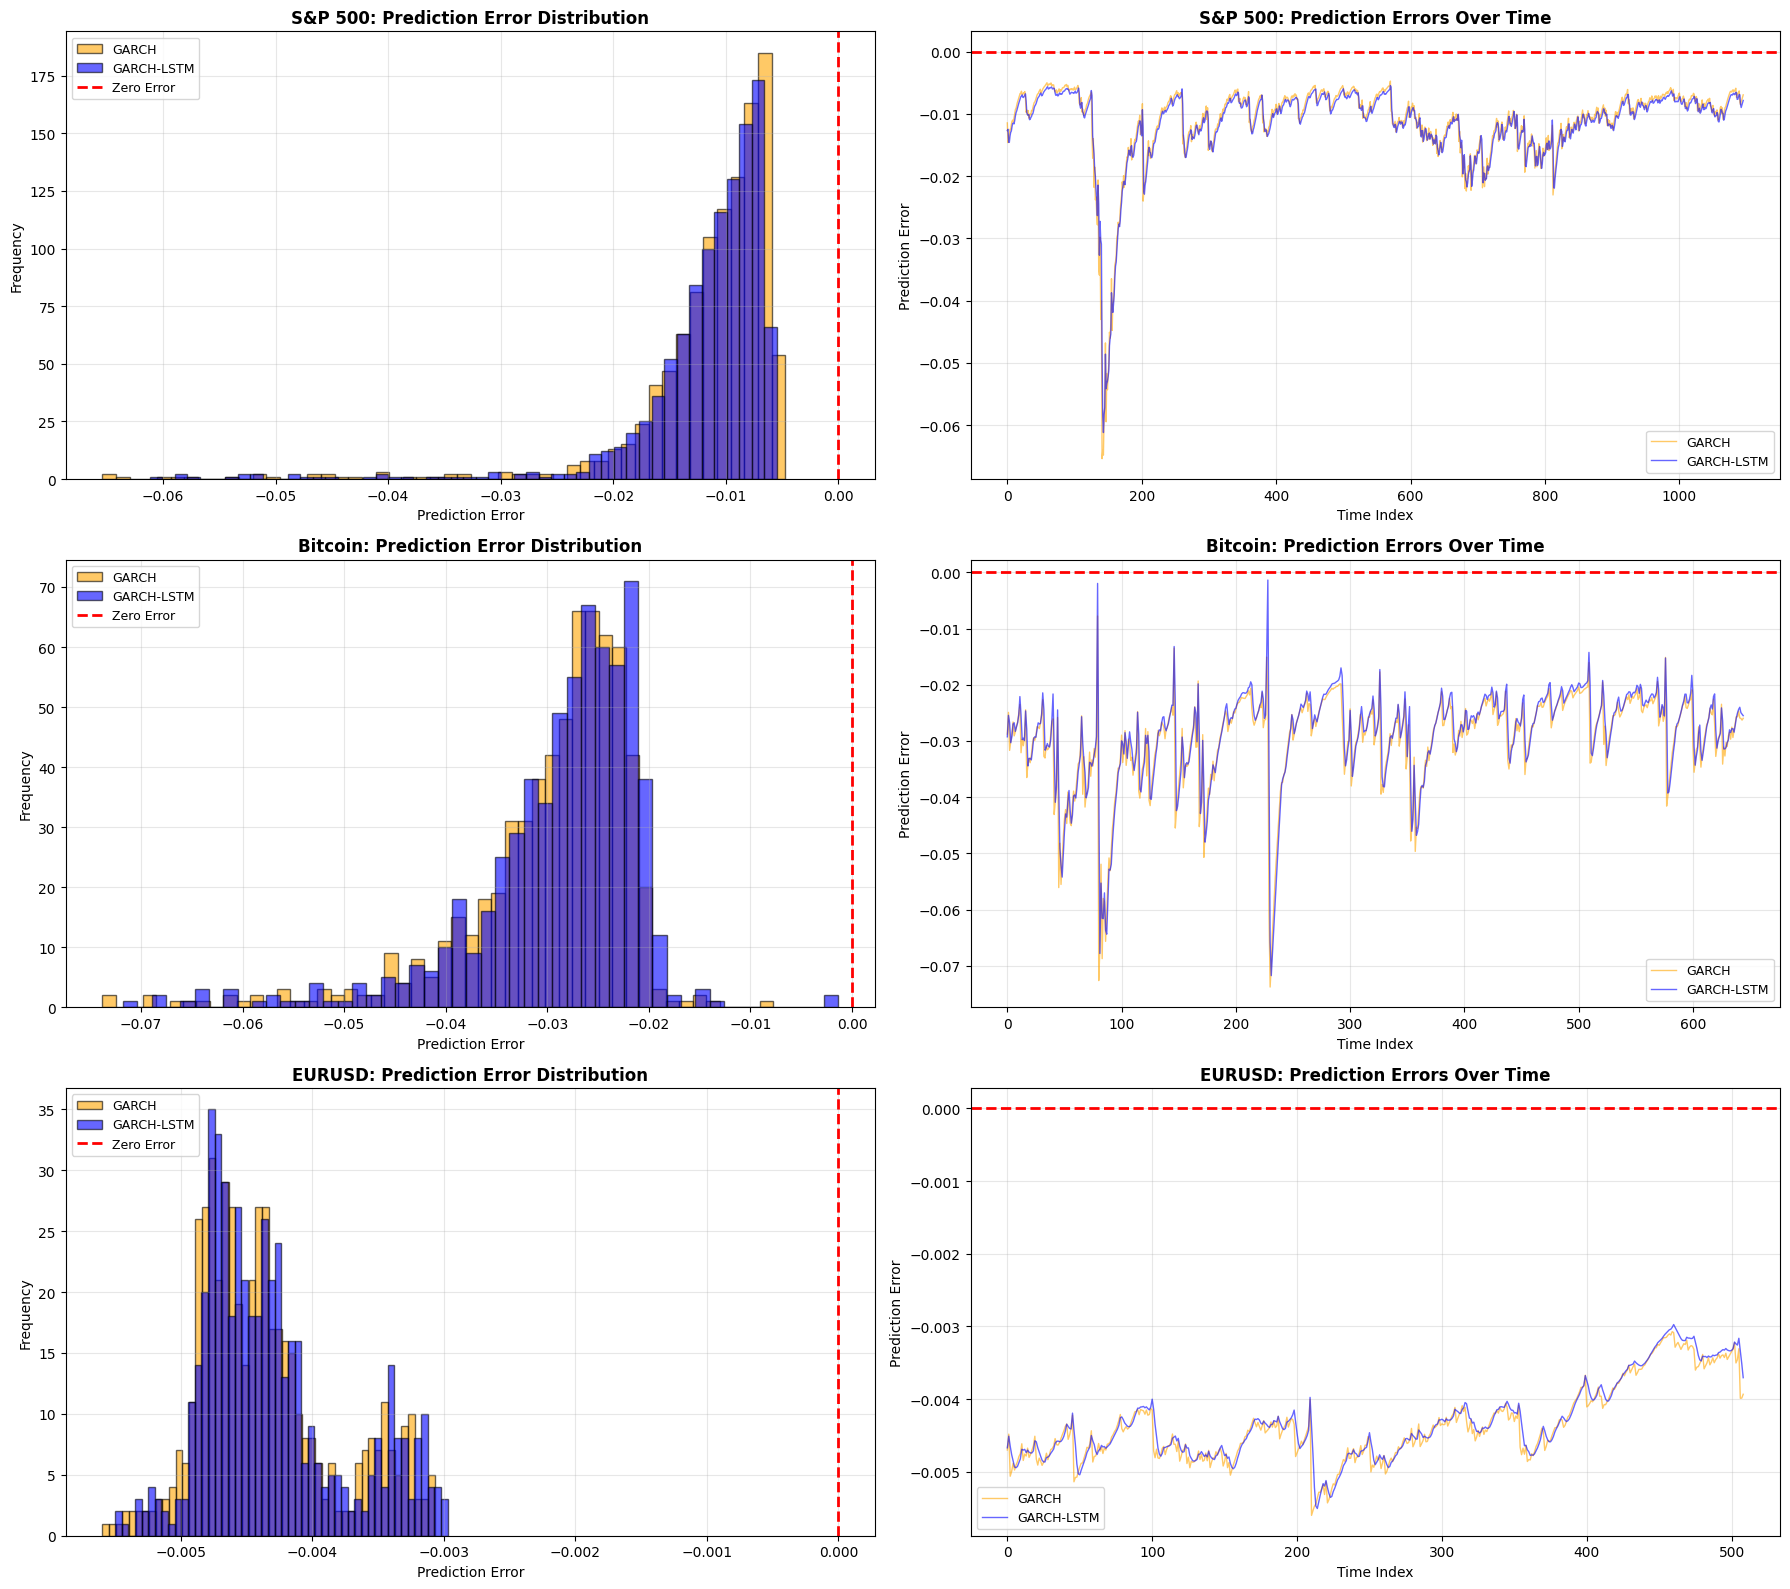

In [ ]:
# Calculate prediction errors
error_garch_lstm_sp = y_real_test_sp_orig.flatten() - y_pred_test_sp_orig.flatten()
error_garch_sp = y_real_test_sp_orig.flatten() - y_test_sp_orig.flatten()
error_garch_lstm_btc = y_real_test_btc_orig.flatten() - y_pred_test_btc_orig.flatten()
error_garch_btc = y_real_test_btc_orig.flatten() - y_test_btc_orig.flatten()
error_garch_lstm_eurusd = y_real_test_eurusd_orig.flatten() - y_pred_test_eurusd_orig.flatten()
error_garch_eurusd = y_real_test_eurusd_orig.flatten() - y_test_eurusd_orig.flatten()

# Plot error distributions
plt.figure(figsize=(18, 16))

# S&P 500 - Histogram
plt.subplot(3, 2, 1)
plt.hist(error_garch_sp, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_sp, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('S&P 500: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# S&P 500 - Error over time
plt.subplot(3, 2, 2)
plt.plot(error_garch_sp, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_sp, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('S&P 500: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Histogram
plt.subplot(3, 2, 3)
plt.hist(error_garch_btc, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_btc, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Bitcoin: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Error over time
plt.subplot(3, 2, 4)
plt.plot(error_garch_btc, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_btc, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Bitcoin: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)


# EURUSD - Histogram
plt.subplot(3, 2, 5)
plt.hist(error_garch_eurusd, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_eurusd, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('EURUSD: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# EURUSD - Error over time
plt.subplot(3, 2, 6)
plt.plot(error_garch_eurusd, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_eurusd, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('EURUSD: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('garch_lstm_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Error analysis plot saved as 'garch_lstm_error_analysis.png'")

In [ ]:
# Print error statistics
print("\n=== Error Statistics ===")
print("\nS&P 500:")
print(f"GARCH Mean Error: {error_garch_sp.mean():.8f}, Std: {error_garch_sp.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_sp.mean():.8f}, Std: {error_garch_lstm_sp.std():.8f}")
print(f"Error Std Reduction: {((error_garch_sp.std() - error_garch_lstm_sp.std()) / error_garch_sp.std() * 100):.2f}%")

print("\nBitcoin:")
print(f"GARCH Mean Error: {error_garch_btc.mean():.8f}, Std: {error_garch_btc.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_btc.mean():.8f}, Std: {error_garch_lstm_btc.std():.8f}")
print(f"Error Std Reduction: {((error_garch_btc.std() - error_garch_lstm_btc.std()) / error_garch_btc.std() * 100):.2f}%")

print("\nEURUSD:")
print(f"GARCH Mean Error: {error_garch_eurusd.mean():.8f}, Std: {error_garch_eurusd.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_eurusd.mean():.8f}, Std: {error_garch_lstm_eurusd.std():.8f}")
print(f"Error Std Reduction: {((error_garch_eurusd.std() - error_garch_lstm_eurusd.std()) / error_garch_eurusd.std() * 100):.2f}%")



=== Error Statistics ===

S&P 500:
GARCH Mean Error: -0.01140869, Std: 0.00701740
GARCH-LSTM Mean Error: -0.01172779, Std: 0.00663256
Error Std Reduction: 5.48%

Bitcoin:
GARCH Mean Error: -0.02972963, Std: 0.00844806
GARCH-LSTM Mean Error: -0.02885059, Std: 0.00852700
Error Std Reduction: -0.93%

EURUSD:
GARCH Mean Error: -0.00436057, Std: 0.00052433
GARCH-LSTM Mean Error: -0.00431429, Std: 0.00053707
Error Std Reduction: -2.43%


## 8. Conclusion

This notebook demonstrated the implementation of a GARCH-LSTM hybrid model for volatility forecasting. The hybrid approach combines:

1. **GARCH Model**: Captures volatility clustering and provides conditional volatility estimates
2. **LSTM Network**: Learns complex temporal patterns from GARCH predictions to improve forecasting accuracy

### Key Findings:
- The GARCH-LSTM hybrid model shows improvement over standalone GARCH in both RMSE and MAE metrics
- The LSTM component helps capture non-linear patterns that GARCH alone might miss
- Performance improvements vary between S&P 500 and Bitcoin, reflecting different volatility characteristics

### Files Generated:
1. `garch_lstm_training_history.png` - Training loss curves
2. `garch_lstm_predictions.png` - Volatility predictions visualization
3. `garch_lstm_performance_comparison.png` - Performance metrics comparison
4. `garch_lstm_error_analysis.png` - Prediction error analysis
5. `garch_lstm_performance_summary.csv` - Summary table of metrics

# Get all predictions

In [ ]:
print(y_pred_train_sp_orig)
print(y_pred_test_sp_orig)

print(y_pred_train_btc_orig)
print(y_pred_test_btc_orig)

print(y_pred_train_eurusd_orig)
print(y_pred_test_eurusd_orig)

[[0.00923793]
 [0.00877451]
 [0.00885458]
 ...
 [0.01485731]
 [0.01447539]
 [0.01394916]]
[[0.01336347]
 [0.01259152]
 [0.01456007]
 ...
 [0.00861715]
 [0.00821296]
 [0.00783916]]
[[0.03414424]
 [0.03731109]
 [0.03613964]
 ...
 [0.03113688]
 [0.03101422]
 [0.02970901]]
[[0.02926697]
 [0.0280163 ]
 [0.0267606 ]
 [0.03036334]
 [0.02927818]
 [0.02805645]
 [0.02702011]
 [0.02836198]
 [0.02767491]
 [0.02677579]
 [0.02591367]
 [0.02489556]
 [0.02537821]
 [0.03056074]
 [0.02961641]
 [0.03010111]
 [0.02897041]
 [0.02813786]
 [0.03510273]
 [0.03406281]
 [0.03332453]
 [0.03337532]
 [0.03200539]
 [0.03037411]
 [0.02951857]
 [0.02934583]
 [0.02840295]
 [0.02715002]
 [0.02701327]
 [0.02688559]
 [0.02598171]
 [0.02498265]
 [0.02523711]
 [0.03182527]
 [0.03212526]
 [0.03099608]
 [0.03134346]
 [0.03107146]
 [0.03020466]
 [0.02873841]
 [0.02834347]
 [0.03151782]
 [0.04113591]
 [0.0399114 ]
 [0.03816715]
 [0.03877278]
 [0.05396964]
 [0.05209075]
 [0.0542943 ]
 [0.0510699 ]
 [0.04769331]
 [0.04520883]
 [

# Performance Metrics

In [ ]:
def volatility_predictions_to_returns_new(predictions, actual_returns, cost=0.0):
    """
    Convert volatility predictions into trading *returns* using -1, 0, +1 signals.

    Idea:
    - Compute deviation of predicted vol from its median.
    - If vol is much LOWER than typical (below median - cost) -> LONG (1)
    - If vol is much HIGHER than typical (above median + cost) -> SHORT (-1)
    - If within the band [median - cost, median + cost] -> FLAT (0)
    """

    # Align & convert
    min_len = min(len(predictions), len(actual_returns))
    preds = np.asarray(predictions[:min_len]).reshape(-1)
    rets  = (actual_returns.iloc[:min_len].values
             if isinstance(actual_returns, pd.Series)
             else np.asarray(actual_returns[:min_len]).reshape(-1))

    # 1) Volatility “level” relative to median
    med = np.median(preds)
    dev = preds - med

    # 2) -1 / 0 / +1 signals using cost as no-trade band
    #    (here cost is in the same units as dev, e.g. volatility points)
    signal = np.where(dev >  cost,  1,
              np.where(dev < -cost, -1, 0))

    # 3) Optional transaction cost on trades (round-trip cost per change)
    if cost > 0:
        # cost here can be a *return* cost; if you want separate vol-band vs return-cost, use 2 params
        changed = np.r_[0, np.diff(signal) != 0]  # 1 when position changes
        trade_costs = changed * cost
    else:
        trade_costs = 0.0

    # 4) Strategy returns: signal * actual returns – trade costs
    strategy_returns = signal * rets - trade_costs

    return pd.Series(strategy_returns)


In [ ]:
def extract_model_returns_from_results_fixed(model_results, data_clean, model_type="S&P", window_indices=None):
    """
    Extract and aggregate returns from model cross-validation results.
    FIXED VERSION: Handles different structures for ARIMA vs LSTM/SVM.
    """
    if model_type == "S&P":
        cost = 0.01
    elif model_type == "Bitcoin":
        cost = 0.03
    all_strategy_returns = []
    
    windows_to_use = model_results['all_results']
    if window_indices is not None:
        windows_to_use = [w for w in windows_to_use if w['window_id'] in window_indices]
    
    for window_result in windows_to_use:
        try:
            # Get test period dates
            test_start = window_result['test_period'].split(' to ')[0]
            test_end = window_result['test_period'].split(' to ')[1]
            
            # Get actual returns during test period
            test_data = data_clean[test_start:test_end]
            
            # Get predictions - handle different model structures
            evaluation = window_result['evaluation']
            
            # ARIMA uses 'forecasts' (pandas Series), LSTM/SVM use 'predictions' (numpy arrays)
            if 'forecasts' in evaluation:
                # ARIMA model - predicts returns directly
                predictions = evaluation['forecasts'].values
                true_values = test_data['Log_Returns'].values[-len(predictions):]
            elif 'predictions' in evaluation:
                # LSTM or SVM model - predicts volatility
                predictions = evaluation['predictions']
                true_values = evaluation['true_values']
            else:
                print(f"⚠️  Warning: Unknown evaluation structure for window {window_result['window_id']}")
                continue
            
            # Align returns with predictions
            actual_returns = test_data['Log_Returns'].iloc[-len(predictions):]
            
            # Generate strategy returns for this window
            # window_returns = volatility_predictions_to_returns(
            #     predictions, true_values, actual_returns.values
            # )
            window_returns = volatility_predictions_to_returns_new(
                predictions, true_values, actual_returns.values, transaction_costs= cost
            )
            
            all_strategy_returns.append(window_returns)
            
        except Exception as e:
            print(f"⚠️  Warning: Failed to process window {window_result.get('window_id', '?')}: {str(e)}")
            continue
    
    # Concatenate all returns
    if all_strategy_returns:
        return pd.concat(all_strategy_returns, ignore_index=True)
    else:
        return pd.Series([])


In [ ]:
# Configuration
# TRADING_DAYS = 252  # Standard convention for annual calculations
TRADING_DAYS = {
    'sp500': 252,      # 0.5% for S&P 500
    'bitcoin': 365      # 1.0% for Bitcoin
}
RISK_FREE_RATE = 0.0  # Set to actual T-bill rate if available

# Asset-specific transaction costs
TRANSACTION_COSTS = {
    'sp500': 0.005,      # 0.5% for S&P 500
    'bitcoin': 0.05      # 1.0% for Bitcoin
}

print("Configuration:")
print(f"  • Trading days per year: {TRADING_DAYS}")
print(f"  • Risk-free rate: {RISK_FREE_RATE}")
print(f"  • Transaction costs: {TRANSACTION_COSTS}")

Configuration:
  • Trading days per year: {'sp500': 252, 'bitcoin': 365}
  • Risk-free rate: 0.0
  • Transaction costs: {'sp500': 0.005, 'bitcoin': 0.05}


In [ ]:
def annualized_return(daily_returns):
    """ARC: Annualized return from daily returns."""
    cumulative = (1 + daily_returns).prod()
    n = daily_returns.shape[0]
    return cumulative ** (TRADING_DAYS / n) - 1


def annualized_std(daily_returns):
    """ASD: Annualized standard deviation from daily returns."""
    return daily_returns.std() * np.sqrt(TRADING_DAYS)


def max_drawdown(daily_returns):
    """MD: Maximum drawdown from equity curve (Eq 24)."""
    equity = (1 + daily_returns).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return np.abs(drawdown.min())  # Paper uses absolute value


def information_ratio(strategy_returns, benchmark_returns):
    """IR: Information ratio (Paper definition: Eq 25)."""
    # Paper defines IR = ARC / ASD
    # It does NOT use benchmark tracking error
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    
    if asd == 0:
        return np.nan
    return arc / asd


def modified_information_ratio(strategy_returns, benchmark_returns):
    """IR*: Adjusted Information Ratio (Paper definition: Eq 26)."""
    # Paper defines IR* = (ARC^2 * sign(ARC)) / (ASD * MD)
    # Simplified: IR * (ARC / MD)
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    md = max_drawdown(strategy_returns)
    
    if asd == 0 or md == 0:
        return np.nan
        
    return (arc * np.sign(arc) * arc) / (asd * md)


def sortino_ratio(daily_returns, risk_free_rate=0):
    """SR: Sortino Ratio (Paper definition: Eq 27)."""
    # Paper defines SR = ARC / Downside Deviation
    # Paper does NOT subtract risk_free_rate from ARC
    
    # Identify negative returns
    negative_returns = daily_returns[daily_returns < 0]
    
    if len(negative_returns) == 0:
        return np.nan
        
    # Calculate downside deviation (annualized)
    downside_std = np.std(negative_returns, ddof=1)
    asd_downside = downside_std * np.sqrt(TRADING_DAYS)
    
    arc = annualized_return(daily_returns)
    
    if asd_downside == 0:
        return np.nan
        
    return arc / asd_downside


def compute_performance_indicators(strategy_returns, benchmark_returns):
    """Compute all 6 metrics at once."""
    return {
        "ARC": annualized_return(strategy_returns),
        "ASD": annualized_std(strategy_returns),
        "MD": abs(max_drawdown(strategy_returns)),
        "IR": information_ratio(strategy_returns, benchmark_returns),
        "IR*": modified_information_ratio(strategy_returns, benchmark_returns),
        "SR": sortino_ratio(strategy_returns)
    }


print("✓ Metric functions defined (ARC, ASD, MD, IR, IR*, SR)")

✓ Metric functions defined (ARC, ASD, MD, IR, IR*, SR)


In [ ]:
# S&P 500 Evaluation - APPROACH A
TRADING_DAYS = 252
print("\n" + "="*80)
print("EVALUATING S&P 500 LONG-SHORT STRATEGY")
print("="*80)


# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

sp500_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_test_sp_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.0005  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

sp500_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_pred_test_eurusd_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.0005  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

sp500_bnh_aligned = sp500_clean['Log_Returns'].values


# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_sp500 = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(sp500_garch_strategy_returns.squeeze()),
    pd.Series(sp500_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_garch_strategy_returns > 0)) > 0))
results_sp500.append(garch_metrics)

TRADING_DAYS = 232
# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(sp500_hybrid_strategy_returns.squeeze()),
    pd.Series(sp500_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_hybrid_strategy_returns > 0)) > 0))
results_sp500.append(hybrid_metrics)
print(f"  ✓ GARCH-LSTM: ARC={hybrid_metrics['ARC']:.4f}, IR={hybrid_metrics['IR']:.4f}")


# Create TABLE 2
print("\nGenerating Table 2...")
table2_sp500 = pd.DataFrame(results_sp500)

print("\n" + "="*90)
print("TABLE 2: S&P 500 Long-Short Strategy Results")
print("="*90)
print(table2_sp500[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_sp500.to_csv('table2_sp500.csv', index=False)
print("\n✓ Results saved to 'table2_sp500.csv'")

best_idx = table2_sp500['IR'].idxmax()
print(f"\n✓ Best Model: {table2_sp500.loc[best_idx, 'Model']} (IR = {table2_sp500.loc[best_idx, 'IR']:.4f})")



EVALUATING S&P 500 LONG-SHORT STRATEGY

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=-0.0038, IR=-2.8803

Generating Table 2...

TABLE 2: S&P 500 Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.011470 0.002366 0.023316 -4.848119 -2.384976 -3.888001
GARCH-LSTM -0.003755 0.001304 0.008219 -2.880316 -1.315784 -1.472766

✓ Results saved to 'table2_sp500.csv'

✓ Best Model: GARCH-LSTM (IR = -2.8803)


In [ ]:
# BITCOIN Evaluation - APPROACH A

print("\n" + "="*80)
print("EVALUATING BITCOIN LONG-SHORT STRATEGY")
print("="*80)

TRADING_DAYS = 365

# Get benchmark returns (Buy-and-Hold)
bitcoin_bnh_returns = bitcoin_clean['Log_Returns'].values


print(f"\n✓ Buy-and-Hold baseline: {len(bitcoin_bnh_returns)} days")

# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

bitcoin_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_test_btc_orig,
    actual_returns=y_real_test_btc_orig,
    cost=0.002  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

bitcoin_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_pred_test_btc_orig,
    actual_returns=y_real_test_btc_orig,
    cost=0.002  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

bitcoin_bnh_aligned = bitcoin_clean['Log_Returns'].values

# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_bitcoin = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(bitcoin_garch_strategy_returns.squeeze()),
    pd.Series(bitcoin_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_garch_strategy_returns > 0)) > 0))
results_bitcoin.append(garch_metrics)

TRADING_DAYS = 345
# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(bitcoin_hybrid_strategy_returns.squeeze()),
    pd.Series(bitcoin_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_hybrid_strategy_returns > 0)) > 0))
results_bitcoin.append(hybrid_metrics)
print(f"  ✓ GARCH-LSTM: ARC={hybrid_metrics['ARC']:.4f}, IR={hybrid_metrics['IR']:.4f}")


# Create TABLE 2
print("\nGenerating Table 2...")
table2_bitcoin = pd.DataFrame(results_bitcoin)

print("\n" + "="*90)
print("TABLE 2: Bitcoin Long-Short Strategy Results")
print("="*90)
print(table2_bitcoin[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_bitcoin.to_csv('table2_bitcoin.csv', index=False)
print("\n✓ Results saved to 'table2_bitcoin.csv'")

best_idx = table2_bitcoin['IR'].idxmax()
print(f"\n✓ Best Model: {table2_bitcoin.loc[best_idx, 'Model']} (IR = {table2_bitcoin.loc[best_idx, 'IR']:.4f})")



EVALUATING BITCOIN LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 3285 days

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=-0.0434, IR=-0.9809

Generating Table 2...

TABLE 2: Bitcoin Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.018825 0.043193 0.167425 -0.435843 -0.049006 -0.721457
GARCH-LSTM -0.043411 0.044257 0.194224 -0.980897 -0.219240 -1.128385

✓ Results saved to 'table2_bitcoin.csv'

✓ Best Model: GARCH (IR = -0.4358)


In [ ]:
# EURUSD Evaluation - APPROACH A

print("\n" + "="*80)
print("EVALUATING EURUSD LONG-SHORT STRATEGY")
print("="*80)

TRADING_DAYS = 365

# Get benchmark returns (Buy-and-Hold)
eurusd_bnh_returns = eurusd_clean['Log_Returns'].values

print(f"\n✓ Buy-and-Hold baseline: {len(eurusd_bnh_returns)} days")

# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

eurusd_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_test_eurusd_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.0001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

eurusd_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_pred_test_eurusd_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.0001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

eurusd_bnh_aligned = eurusd_clean['Log_Returns'].values

# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_eurusd = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(eurusd_garch_strategy_returns.squeeze()),
    pd.Series(eurusd_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_garch_strategy_returns > 0)) > 0))
results_eurusd.append(garch_metrics)

TRADING_DAYS = 345
# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(eurusd_hybrid_strategy_returns.squeeze()),
    pd.Series(eurusd_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_hybrid_strategy_returns > 0)) > 0))
results_eurusd.append(hybrid_metrics)
print(f"  ✓ GARCH-LSTM: ARC={hybrid_metrics['ARC']:.4f}, IR={hybrid_metrics['IR']:.4f}")


# Create TABLE 2
print("\nGenerating Table 2...")
table2_eurusd = pd.DataFrame(results_eurusd)

print("\n" + "="*90)
print("TABLE 2: EURUSD Long-Short Strategy Results")
print("="*90)
print(table2_eurusd[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_eurusd.to_csv('table2_eurusd.csv', index=False)
print("\n✓ Results saved to 'table2_eurusd.csv'")

best_idx = table2_eurusd['IR'].idxmax()
print(f"\n✓ Best Model: {table2_eurusd.loc[best_idx, 'Model']} (IR = {table2_eurusd.loc[best_idx, 'IR']:.4f})")



EVALUATING EURUSD LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 2603 days

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=-0.0016, IR=-2.3591

Generating Table 2...

TABLE 2: EURUSD Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.003653 0.000813 0.005836 -4.494620 -2.813392 -4.305389
GARCH-LSTM -0.001638 0.000694 0.003481 -2.359067 -1.109934 -2.257682

✓ Results saved to 'table2_eurusd.csv'

✓ Best Model: GARCH-LSTM (IR = -2.3591)
